In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import warnings
import re
import requests
from bs4 import BeautifulSoup
from IPython.display import display_html 

warnings.filterwarnings("ignore")
pd.options.display.max_seq_items = 2000

# Sources:
# https://www.bikeshare.com/data/
# https://www.bluebikes.com/system-data
# https://crashviewer.nhtsa.dot.gov/CrashAPI
# https://hifld-geoplatform.opendata.arcgis.com/datasets/hospitals/data?selectedAttribute=BEDS Hospital Data
# https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population Cities

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# So the dataset is retrieved from: https://crashviewer.nhtsa.dot.gov/CrashAPI
#GET FARS data from accident, pbtype, and vehicle tables 
fars_acc2018 = pd.read_csv('data/FARS/FARS2018/ACCIDENT.csv')
fars_acc2017 = pd.read_csv('data/FARS/FARS2017/ACCIDENT.csv')
fars_acc2016 = pd.read_csv('data/FARS/FARS2016/ACCIDENT.csv')

fars_PB2018 = pd.read_csv('data/FARS/FARS2018/PBTYPE.csv')
fars_PB2017 = pd.read_csv('data/FARS/FARS2017/PBTYPE.csv')
fars_PB2016 = pd.read_csv('data/FARS/FARS2016/PBTYPE.csv')

fars_veh2018 = pd.read_csv('data/FARS/FARS2018/VEHICLE.csv',encoding= 'unicode_escape')
fars_veh2017 = pd.read_csv('data/FARS/FARS2017/VEHICLE.csv',encoding= 'unicode_escape')
fars_veh2016 = pd.read_csv('data/FARS/FARS2016/VEHICLE.csv',encoding= 'unicode_escape')

#Load Top10 Cities data
cities_df = pd.read_csv('data/Cities.csv')
#Load GLC data to add city and county to FARS data
GLC = pd.read_excel('data/FRPP_GLC_-_United_StatesDEC72020.xlsx')

In [4]:
#Join FARS accident and vehicle tables on state and st_case
fars_acc_veh_2018 = pd.merge(fars_acc2018, fars_veh2018,  how='left', left_on=['STATE','ST_CASE'], right_on = ['STATE','ST_CASE'])
fars_acc_veh_2017 = pd.merge(fars_acc2017, fars_veh2017,  how='left', left_on=['STATE','ST_CASE'], right_on = ['STATE','ST_CASE'])
fars_acc_veh_2016 = pd.merge(fars_acc2016, fars_veh2016,  how='left', left_on=['STATE','ST_CASE'], right_on = ['STATE','ST_CASE'])

In [5]:
#Join FARS accident and vehicle tables on state and st_case
fars_all_2018 = pd.merge(fars_acc_veh_2018, fars_PB2018,  how='left', left_on=['STATE','ST_CASE'], right_on = ['STATE','ST_CASE'])
fars_all_2017 = pd.merge(fars_acc_veh_2017, fars_PB2017,  how='left', left_on=['STATE','ST_CASE'], right_on = ['STATE','ST_CASE'])
fars_all_2016 = pd.merge(fars_acc_veh_2016, fars_PB2016,  how='left', left_on=['STATE','ST_CASE'], right_on = ['STATE','ST_CASE'])

In [6]:
FARS_3yrs_withPB = fars_all_2018.append([fars_all_2017, fars_all_2016])

In [7]:
#One more step for FARS, get city name and county name from GLC
#As some city level data can't be matched, so we match the city first, and then match state again to replace the nan value if city couldn't be matched.
FARS_GLC=pd.merge(FARS_3yrs_withPB, GLC[['State Code','County Code','County Name','State Name','City Code','City Name']],  how='left', left_on=['COUNTY','STATE','CITY'], right_on = ['County Code','State Code','City Code'])
FARS_GLC2=pd.merge(FARS_GLC, GLC[['State Code','County Code','County Name','State Name']],  how='left', left_on=['COUNTY','STATE'], right_on = ['County Code','State Code'])
#FARS_GLC2.head(40)

In [8]:
FARS_GLC2=FARS_GLC2.drop(['State Code_x','County Code_x','County Name_x','State Name_x'], axis=1)
FARS_GLC2.rename(columns={'State Code_y':'State Code', 'County Code_y':'County Code','County Name_y':"County Name",'State Name_y':'State Name'},inplace=True)

In [9]:
FARS_16_17_18=FARS_GLC2.copy()
FARS_16_17_18.head()

STATE  ST_CASE  VE_TOTAL  VE_FORMS_x  PVH_INVL  PEDS  PERNOTMVIT  PERMVIT  PERSONS  COUNTY  CITY  DAY_x  MONTH_x  YEAR  DAY_WEEK  HOUR_x  MINUTE_x  NHS  RUR_URB  FUNC_SYS  RD_OWNER  ROUTE TWAY_ID TWAY_ID2  MILEPT   LATITUDE   LONGITUD  SP_JUR  HARM_EV_x  MAN_COLL_x  RELJCT1  RELJCT2  TYP_INT  WRK_ZONE  REL_ROAD  LGT_COND  WEATHER1  WEATHER2  WEATHER  SCH_BUS     RAIL  NOT_HOUR  NOT_MIN  ARR_HOUR  ARR_MIN  HOSP_HR  HOSP_MN  CF1  CF2  CF3  FATALS  DRUNK_DR  VEH_NO_x  VE_FORMS_y  NUMOCCS  DAY_y  MONTH_y  HOUR_y  MINUTE_y  HARM_EV_y  MAN_COLL_y  UNITTYPE  HIT_RUN  REG_STAT  OWNER  MAKE  MODEL  MAK_MOD  BODY_TYP  MOD_YEAR           VIN VIN_1 VIN_2 VIN_3 VIN_4 VIN_5 VIN_6 VIN_7 VIN_8 VIN_9 VIN_10 VIN_11 VIN_12  TOW_VEH  J_KNIFE  MCARR_I1 MCARR_I2  MCARR_ID  GVWR  V_CONFIG  CARGO_BT  HAZ_INV  HAZ_PLAC  HAZ_ID  HAZ_CNO  HAZ_REL  BUS_USE  SPEC_USE  EMER_USE  TRAV_SP  UNDERIDE  ROLLOVER  ROLINLOC  IMPACT1  DEFORMED  TOWED  M_HARM  VEH_SC1  VEH_SC2  FIRE_EXP  DR_PRES  L_STATE  DR_ZIP  \
0      1    10001         2           1         1     0           0        1        1     121  1870      5        1  2018         6       6         0    1        1         1         1      1    I-20      NaN    1676  33.591331 -86.131869       0         14           0        0        1        1         0         2         4         1         0        1        0  0000000         6       99         6       15       88       88    0    0    0       1         0         1           1        1      5        1       6         0         14           0         1        0         1      2    82    881    82881        66      2018  1FUBGDFG0JLJ     1     F     U     B     G     D     F     G     0      J      L      J        1        1        57   978310  57978310     3         6         1        1         0       0        0        0        0         0         0       60         0         1         1       12         6      2       1        0        0         0        1        1   35211   
1      1    10001         2           1         1     0           0        1        1     121  1870      5        1  2018         6       6         0    1        1         1         1      1    I-20      NaN    1676  33.591331 -86.131869       0         14           0        0        1        1         0         2         4         1         0        1        0  0000000         6       99         6       15       88       88    0    0    0       1         0         1           1        1      5        1       6         0         14           0         1        0         1      2    82    881    82881        66      2018  1FUBGDFG0JLJ     1     F     U     B     G     D     F     G     0      J      L      J        1        1        57   978310  57978310     3         6         1        1         0       0        0        0        0         0         0       60         0         1         1       12         6      2       1        0        0         0        1        1   35211   
2      1    10001         2           1         1     0           0        1        1     121  1870      5        1  2018         6       6         0    1        1         1         1      1    I-20      NaN    1676  33.591331 -86.131869       0         14           0        0        1        1         0         2         4         1         0        1        0  0000000         6       99         6       15       88       88    0    0    0       1         0         1           1        1      5        1       6         0         14           0         1        0         1      2    82    881    82881        66      2018  1FUBGDFG0JLJ     1     F     U     B     G     D     F     G     0      J      L      J        1        1        57   978310  57978310     3         6         1        1         0       0        0        0        0         0         0       60         0         1         1       12         6      2       1        0        0         0        1        1   35211   
3      1    10001         2

In [10]:
#GET CRSS data from accident, pbtype, and vehicle tables 
crss_acc2018 = pd.read_csv('data/CRSS/CRSS2018/ACCIDENT.csv')
crss_acc2017 = pd.read_csv('data/CRSS/CRSS2017/ACCIDENT.csv')
crss_acc2016 = pd.read_csv('data/CRSS/CRSS2016/ACCIDENT.csv')

crss_PB2018 = pd.read_csv('data/CRSS/CRSS2018/PBTYPE.csv')
crss_PB2017 = pd.read_csv('data/CRSS/CRSS2017/PBTYPE.csv')
crss_PB2016 = pd.read_csv('data/CRSS/CRSS2016/PBTYPE.csv')

crss_veh2018 = pd.read_csv('data/CRSS/CRSS2018/VEHICLE.csv',encoding= 'unicode_escape')
crss_veh2017 = pd.read_csv('data/CRSS/CRSS2017/VEHICLE.csv',encoding= 'unicode_escape')
crss_veh2016 = pd.read_csv('data/CRSS/CRSS2016/VEHICLE.csv',encoding= 'unicode_escape')

In [11]:
#Join CRSS accident and vehicle tables on state and st_case
crss_acc_veh_2018 = pd.merge(crss_acc2018, crss_veh2018,  how='left', left_on=['CASENUM'], right_on = ['CASENUM'])
crss_acc_veh_2017 = pd.merge(crss_acc2017, crss_veh2017,  how='left', left_on=['CASENUM'], right_on = ['CASENUM'])
crss_acc_veh_2016 = pd.merge(crss_acc2016, crss_veh2016,  how='left', left_on=['CASENUM'], right_on = ['CASENUM'])

In [12]:
crss_all_2018 = pd.merge(crss_acc_veh_2018, crss_PB2018,  how='left', left_on=['CASENUM','VEH_NO'], right_on = ['CASENUM','VEH_NO'])
crss_all_2017 = pd.merge(crss_acc_veh_2017, crss_PB2017,  how='left', left_on=['CASENUM','VEH_NO'], right_on = ['CASENUM','VEH_NO'])
crss_all_2016 = pd.merge(crss_acc_veh_2016, crss_PB2016,  how='left', left_on=['CASENUM','VEH_NO'], right_on = ['CASENUM','VEH_NO'])

In [13]:
CRSS_16_17_18 = crss_all_2018.append([crss_all_2017, crss_all_2016])

In [14]:
# Web Scrap to collect biggest US cities by population
# Get URL, request HTML and create soup
URL = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population'
page = requests.get(URL)
page.content
soup = BeautifulSoup(page.content, 'html.parser')

# Find all tables and table for interest is table 4, extract it and send it to DF
table = soup.find_all('table')
top_cities = pd.read_html(str(table))[4]

# cities_df = pd.read_csv('data/Cities.csv')
#Extract Lat and Long independently to plot cities and convert to float
top_cities['Lat'] = top_cities['Location'].str.extract('(\d+\.\d+)').astype(float)
top_cities['Lon'] = (top_cities['Location'].str.extract('\s(\d+\.\d+)').astype(float))*-1

#Convert Lat and Long to radians to faciliate creating a radius for the city
top_cities['Lat_rad'] = top_cities['Lat'] * np.pi / 180
top_cities['Lon_rad'] = top_cities['Lon'] * np.pi / 180

# Get land area in km2 (Clean and extract number only)
top_cities['Land'] = top_cities['2016 land area.1'].str.extract('([\d,]+\.\d+)').replace(',','')
top_cities['Land'] = top_cities['Land'].str.replace(',','').astype(float)

#Clean City name
top_cities['City'] = top_cities['City'].str.replace(r"\[.*\]", '')
# top_cities

# #Remove commas and units for numerical values
# cities_df['Estimate 2019'] = cities_df['Estimate 2019'].str.replace(',','').astype(float)
# cities_df['Census 2010'] = cities_df['Census 2010'].str.replace(',','').astype(float)

In [15]:
##PLOT a count of accidents by year and month
yr_month_count=FARS_16_17_18.groupby(['YEAR','MONTH_x']).ST_CASE.nunique().reset_index().rename(columns={'ST_CASE':'count'})
Months_name = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 
          7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
yr_month_count=yr_month_count.replace({"MONTH_x": Months_name})


months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
yr_month_count['month'] = pd.Categorical(yr_month_count['MONTH_x'], categories=months, ordered=True)

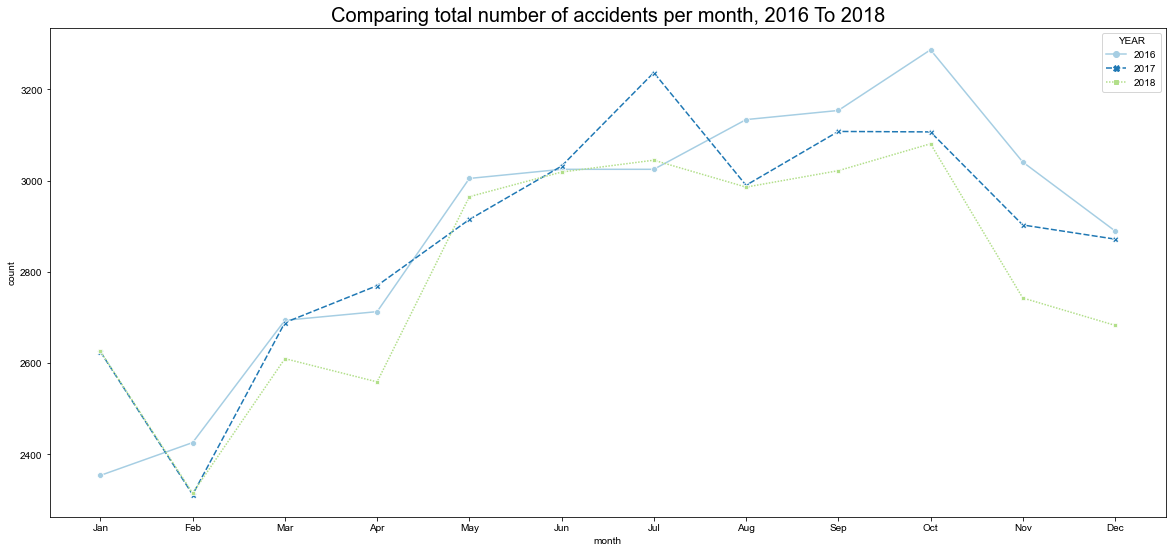

In [16]:
#Comparison of number of fatal accidents from 2016 to 2018
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
yr_month_count['month'] = pd.Categorical(yr_month_count['MONTH_x'], categories=months, ordered=True)
plt.figure(figsize=(20,9))
ax =sns.lineplot(data = yr_month_count, x='month',y='count', hue='YEAR',style="YEAR",ci=None,palette="Paired",markers=True)
ax.set_title('Comparing total number of accidents per month, 2016 To 2018',fontsize=20)
sns.set(font_scale=2)
sns.set_style("white")

plt.show()

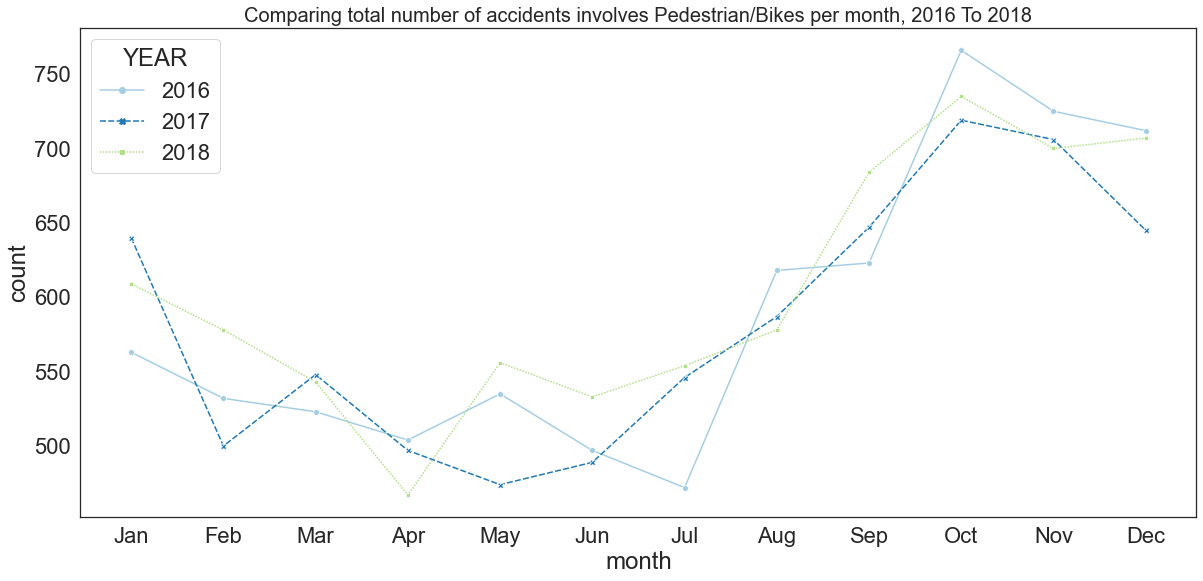

In [17]:
pb=FARS_16_17_18[FARS_16_17_18['PBPTYPE'].notna()]
yr_month_count_pb=pb.groupby(['YEAR','MONTH_x']).ST_CASE.nunique().reset_index().rename(columns={'ST_CASE':'count'})

Months_name = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 
          7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
yr_month_count_pb=yr_month_count_pb.replace({"MONTH_x": Months_name})

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
yr_month_count_pb['month'] = pd.Categorical(yr_month_count_pb['MONTH_x'], categories=months, ordered=True)
plt.figure(figsize=(20,9))
ax =sns.lineplot(data = yr_month_count_pb, x='month',y='count', hue='YEAR',style="YEAR",ci=None,palette="Paired",markers=True)
ax.set_title('Comparing total number of accidents involves Pedestrian/Bikes per month, 2016 To 2018',fontsize=20)
sns.set(font_scale=2)
sns.set_style("white")

plt.show()

In [18]:
#Create copy of data
FARS=FARS_16_17_18.copy()
CRSS=CRSS_16_17_18.copy()
#Replace integer with actual values
Light_Cond = {1:"Daylight", 2:"Dark – Not Lighted", 3:"Dark – Lighted", 4:"Dawn", 5:"Dusk", 6:"Dark – Unknown Lighting", 
          7:"Other", 8:"Not Reported", 9:"Unknown/Reported as Unknown", 10:"Oct", 11:"Nov", 12:"Dec"}
FARS=FARS.replace({"LGT_COND": Light_Cond})
CRSS=CRSS.replace({"LGT_COND": Light_Cond})

Alc_inv = {1:"Alcohol Involved", 2:"No Alcohol Involved",  8:"No Applicable Person",9:"Unknown"}
CRSS=CRSS.replace({"ALCOHOL": Alc_inv})

Weather_str={0:"No Additional Atmospheric Conditions", 1:"Clear", 2:"Rain", 3:"Sleet or Hail", 4:"Snow", 
         5:"Fog, Smog, Smoke", 6:"Severe Crosswinds", 
        7:"Blowing Sand, Soil, Dirt", 8:"Other",  
        10:"Cloudy", 11:"Blowing Snow", 12:"Freezing Rain or Drizzle",
        98:"Unknown/Reported as Unknown",
        99:"Unknown/Reported as Unknown"}
FARS=FARS.replace({"WEATHER": Weather_str})
CRSS=CRSS.replace({"WEATHER": Weather_str})

Manner_collison={0:"Not Collision with Motor Vehicle in Transport", 1:"Front-to-Rear", 2:"Front-to-Front",
                 3:"Angle – Front-to-Side, Same Direction", 4:"Angle – Front-to-Side, Opposite Direction", 
         5:"Angle – Front-to-Side, Right Angle (Includes Broadside)", 
        6:"Angle – Front-to-Side/Angle-Direction Not Specified", 
        7:"Sideswipe – Same Direction", 8:"Sideswipe – Opposite Direction",
        9:"Rear-to-Side",
        10:"Rear-to-Rear", 11:"Other (End-Swipes and Others)", 
        98:"Not Reported",
        99:"Unknown/Reported as Unknown"}
FARS=FARS.replace({"MAN_COLL_x": Manner_collison})
CRSS=CRSS.replace({"MAN_COLL_x": Manner_collison})


Rel_Roads={1:"On Roadway", 2:"On Shoulder", 3:"On Median", 4:"On Roadside", 
         5:"Outside Trafficway", 6:"Off Roadway – Location Unknown", 
        7:"In Parking Lane/Zone", 8:"Gore",  
        10:"Separator", 11:"Continuous Left Turn Lane", 
        12:"Unknown/Reported as Unknown",
        98:"Not Reported",
        99:"Unknown/Reported as Unknown"}

FARS=FARS.replace({"REL_ROAD": Rel_Roads})
CRSS=CRSS.replace({"REL_ROAD": Rel_Roads})


Level_Damage_Veh={0:"No Damage", 2:"Minor Damage", 4:"Functional Damage", 
         6:"Disabling Damage", 8:"Not Reported", 
     9:"Reported as Unknown"
        }

FARS=FARS.replace({"DEFORMED": Level_Damage_Veh})
CRSS=CRSS.replace({"DEFORMED": Level_Damage_Veh})


Haz_Involve={1:"No", 2:"Yes"
        }

FARS=FARS.replace({"HAZ_INV": Haz_Involve})
CRSS=CRSS.replace({"HAZ_INV": Haz_Involve})

Roll_over={0:"No Rollover", 1:"Rollover, Tripped by Object/Vehicle Subsequent Event",
           2:"Rollover, Untripped",
           9:"Rollover, Unknown Type"
        }

FARS=FARS.replace({"ROLLOVER": Roll_over})
CRSS=CRSS.replace({"ROLLOVER": Roll_over})


Fire={0:"No or Not Reported", 1:"Yes"}

FARS=FARS.replace({"FIRE_EXP": Fire})
CRSS=CRSS.replace({"FIRE_EXP": Fire})

In [19]:
#The parts below is for fatal accidents analysis

Sur_type={0:"Non-Trafficway or Driveway Access",
         1:"Concrete",
         2:"Blacktop, Bituminous, or Asphalt",
         3:"Brick or Block",
         4:"Slag, Gravel or Stone",
         5:"Dirt",
         7:"Other",
         8:"Not Reported",
         9:"Unkown/Reported as Unknown"}

FARS=FARS.replace({"VPAVETYP": Sur_type})

Surf_cond={0:"Non-Trafficway Area or Driveway Access",
          1:"Dry",
          2:"Wet",
          3:"Snow",
          4:"Ice/Frost",
          5:"Sand",
          6:"Water (Standing or Moving)",
          7:"Oil",
          8:"Other",
          10:"Slush",
          11:"Mud, Dirt, Gravel",
          98:"Not Reported",
          99:"Unknown/Reported as Unknown"}

FARS=FARS.replace({"VSURCOND": Surf_cond}) 


Vehicle_make={1:"American Motors",
             2:"Jeep/Kaiser-Jeep/Willys Jeep",
             3:"AM General",
             6:"Chrysler",
             7:"Dodge",
             8:"Imperial",
             9:"Plymouth",
             10:"Eagle",
             12:"Ford",
             13:"Lincoln",
             14:"Mercury",
             18:"Buick/Opel",
             19:"Cadillac",
             20:"Chevrolet",
             21:"Oldsmobile",
             22:"Pontiac",
             23:"GMC",
             24:"Saturn",
             25:"Grumman",
             26:"Coda (Since 2013)",
             29:"Other Domestic (Avanti Checker DeSoto Excalibur Hudson Packard Panoz Saleen Studebaker Stutz Tesla (Since 2014))",
             30:"30 Volkswagen",
             31:"Alfa Romeo",
             32:"Audi",
             33:"Austin/Austin Healey",
             34:"BMW",
             35:"Datsun/Nissan",
             36:"Fiat",
             37:"Honda",
             38:"Isuzu",
             39:"Jaguar",
             40:"Lancia",
             41:"Mazda",
             42:"Mercedes-Benz",
             43:"MG",
             44:"Peugeot",
             45:"Porsche",
             46:"Renault",
             47:"Saab",
             48:"Subaru",
             49:"Toyota",
             50:"Triumph",
             51:"Volvo",
             52:"Mitsubishi",
             53:"Suzuki",
             54:"Acura",
             55:"Hyundai",
             56:"Merkur",
             57:"Yugo",
             58:"Infiniti",
             59:"Lexus",
             60:"Daihatsu",
             61:"Sterling",
             62:"Land Rover",
             63:"Kia",
             64:"Daewoo",
             65:"Smart (Since 2010)",
             66:"Mahindra (2011-2013)",
             67:"Scion (Since 2012)",
             69:"Other Imports (such as Aston Martin Bentley Bertone Bricklin Bugatti Caterham Citroen DeLorean Desta Ferrari Lamborghini Mini Cooper Morgan",
             70:"BSA",
             71:"Ducati",
             72:"Harley-Davidson",
             73:"Kawasaki",
             74:"Moto Guzzi",
             75:"Norton",
             76:"Yamaha",
             77:"Victory",
             78:"Other Make Moped (Since 2010)",
             79:"Other Make Motored Cycle (Since 2010)",
             80:"Brockway",
             81:"Diamond Reo/Reo",
             82:"Freightliner",
             83:"FWD",
             84:"International Harvester/Navistar",
             85:"Kenworth",
             86:"Mack",
             87:"Peterbilt",
             88:"Iveco/Magirus",
             89:"White/Autocar, White/GMC",
             90:"Bluebird",
             91:"Eagle Coach",
             92:"Gillig",
             93:"MCI",
             94:"Thomas Built",
             97:"Not Reported (Since 2010)",
             98:"Other Make Auto-Union-DKW Carpenter Collins Bus DINA Divco Hino Mid Bus Neoplan Orion Oshkosh Scania Sterling UD Van Hool Western Star",
             99:"Unknown Make"}


FARS=FARS.replace({"MAKE": Vehicle_make})              
     
Bodytype={1:"Convertible (Excludes Sunroof, T-Bar)", 
          2:"2-Door Sedan/Hardtop/Coupe",         
          3:"3-Door/2-Door Hatchback",
          4:"4-Door Sedan/Hardtop",
          5:"5-Door/4-Door Hatchback",
          6:"Station Wagon (Excluding Van and Truck-Based)",
          7: "Hatchback, Number of Doors Unknown",
          8:"Sedan/Hardtop, Number of Doors Unknown (Since 1994)",
          9:"Other or Unknown Automobile Type (Since 1994)",
          10:"Auto-Based Pickup",
          11:"Auto-Based Panel (Cargo Station Wagon, Auto-Based Ambulance or Hearse)",
          12:"Large Limousine – More Than Four Side Doors or Stretch Chassis",
          13:"Three-Wheel Automobile or Automobile Derivative",
          14:"Compact Utility (ANSI D-16 Utility Vehicle Categories “Small” and “Midsize”)",
          15:"Large Utility (ANSI D-16 Utility Vehicle Categories “Full Size” and “Large”)",
          16:"Utility Station Wagon",
          17:"3-Door Coupe",
          19:"Utility Unknown Body",
          20:"Minivan",
          21:"Large Van – Includes Van-Based Buses",
          22:"Step Van or Walk-In Van (GVWR ≤ 10,000 lbs)",
          28:"Other Van Type (Hi-Cube Van)",
          29:"Unknown Van Type",
          30:"Compact Pickup (GVWR, < 4,500 lbs)",
          31:"Standard Pickup (4,500 lbs <= GVWR < 10,000 lbs)",
          32:"Pickup with Slide-In Camper",
          33:"Convertible Pickup",
          34:"Light Pickup",
          39:"Unknown (Pickup Style) Light Conventional Truck Type",
          40:"Cab Chassis-Based (Includes Light Stake, Light Dump, Light Tow, Rescue Vehicles)",
          41:"Truck-Based Panel",
          42:"Light-Truck-Based Motorhome (Chassis Mounted)",
          45:"Other Light Conventional Truck Type (Includes Stretched Suburban Limousine)",
          48:"Unknown Light Truck Type (Since 2013)",
          49:"Unknown Light-Vehicle Type (Automobile, Utility Vehicle, Van or Light Truck)",
          50:"School Bus",
          51:"Cross-Country/Intercity Bus (i.e., Greyhound)",
          52:"Transit Bus (City Bus)",
          55:"Van-Based Bus (GVWR > 10,000 lbs) (Since 2011)",
          58:"Other Bus Type",
          59:"Unknown Bus Type",
          60:"Step Van (GVWR > 10,000 lbs.)",
          61:"Single-Unit Straight Truck or Cab-Chassis (GVWR range 10,001 to 19,500 lbs) (Since 2011)",
          62:"Single-Unit Straight Truck or Cab-Chassis (GVWR range 19,501 to 26,000 lbs) (Since 2011)",
          63:"Single-Unit Straight Truck or Cab-Chassis (GVWR > 26,000 lbs) (Since 2011)",
          64:"Single Unit Straight Truck or Cab-Chassis (GVWR Unknown) (Since 2011)",
          65:"Medium/Heavy Truck-Based Motorhome",
          66:"Truck/Tractor (Cab Only, or with Any Number of Trailing Units: Any Weight)",
          67:"Medium/Heavy Pickup (GVWR > 10,000 lbs) (Since 2001)",
          72:"Unknown if Single-Unit or Combination-Unit Heavy Truck (GVWR > 26,000 lbs)",
          73:"Camper or Motorhome, Unknown Truck Type",
          78:"Unknown Medium/Heavy Truck Type",
          79:"Unknown Truck Type",
          80:"Two Wheel Motorcycle (excluding motor scooters)",
          81:"Moped or Motorized Bicycle",
          82:"Three-Wheel Motorcycle (2 Rear Wheels)",
          83:"Off-Road Motorcycle",
          84:"Motor Scooter",
          85:"Unenclosed 3-Wheel Motorcycle / Unenclosed Autocycle (1 Rear Wheel)",
          86:"Enclosed 3-Wheel Motorcycle / Enclosed Autocycle (1 Rear Wheel)",
          87:"Unknown Three Wheel Motorcycle Type",
          88:"Other Motored Cycle Type (Mini-Bikes, Pocket Motorcycles, 'Pocket Bikes')",
          89:"Unknown Motored Cycle Type",
          90:"ATV (All-Terrain Vehicle; Includes 3 or 4 Wheels)",
          91:"Snowmobile",
          92:"Farm Equipment Other Than Trucks",
          93:"Construction Equipment Other Than Trucks (Includes Graders)",
          94:"Low Speed Vehicle (LSV)/Neighborhood Electric Vehicle (NEV) (Since 2011)",
          95:"Golf Cart (Since 2012)",
          96:"Recreational Off-Highway Vehicle",
          97:"Other Vehicle Type (Includes Go-Cart, Fork-Lift, City Street Sweeper, Dune/Swamp Buggy)",
          98:"Not Reported",
          99:"Unknown Body Type"}  
FARS=FARS.replace({"BODY_TYP": Bodytype})  



### Let's compare major factors between fatal crash and injury-only crash.

##### First, let's take a look at light condition between Fatal and Injury-only Crash.
From the visualization, the majority of accidents in both types of accidents happen under the condition of 'Daylight'. However, more percentage of fatal accidents happened in 'Dark-Lighted', 'Dark-Not lighted' compared to injury-only accidents. 
So light condition is an important factor.

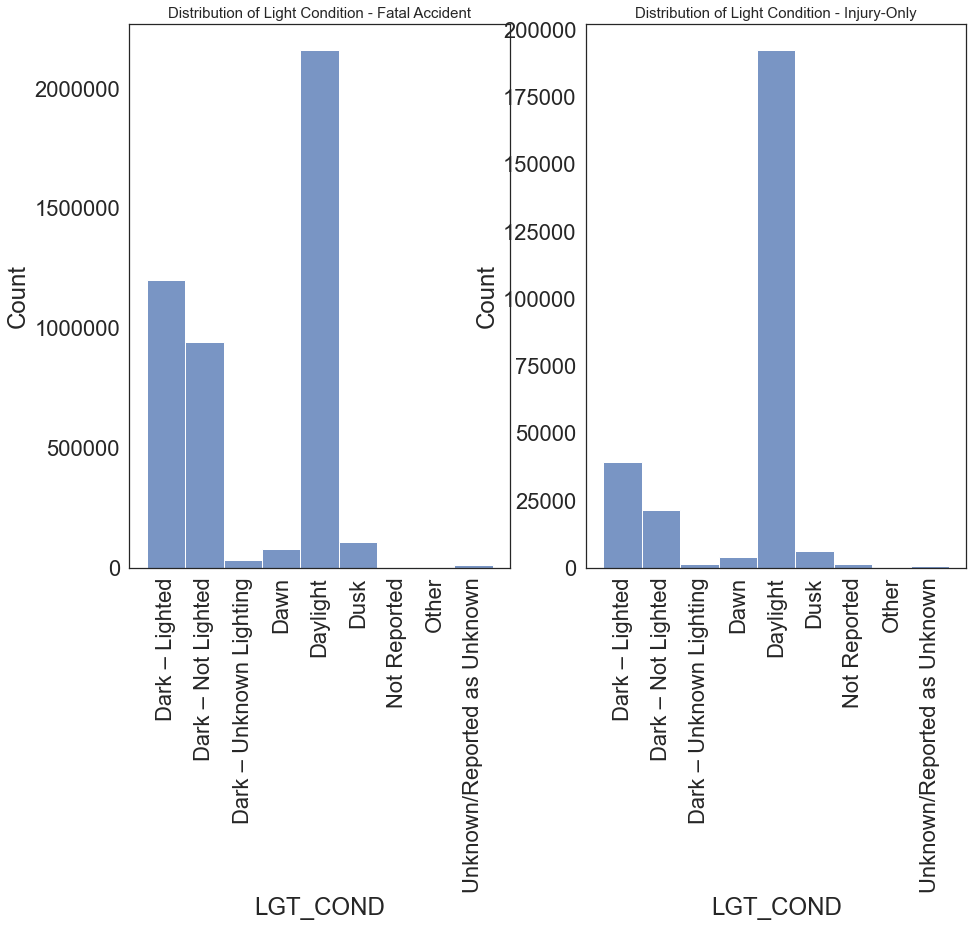

In [20]:
FARS.dropna(subset=['LGT_COND'],inplace = True)
CRSS.dropna(subset=['LGT_COND'],inplace = True)
FARS_sort = FARS.sort_values('LGT_COND',ascending=True)
CRSS_sort = CRSS.sort_values('LGT_COND',ascending=True)
f,ax=plt.subplots(1,2,figsize=(15,10))
sns.set(font_scale=1)
rc={'font.size': 10, 'axes.labelsize': 12, 
    'axes.titlesize': 15, 'xtick.labelsize':8, 'ytick.labelsize': 8}
sns.set_context(rc=rc)
sns.set_style("white")

sns.histplot(FARS_sort["LGT_COND"],ax=ax[0])
ax[0].set_title('Distribution of Light Condition - Fatal Accident')
plt.setp(ax[0].get_xticklabels(), rotation=90)
ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)


sns.histplot(CRSS_sort["LGT_COND"],ax=ax[1])
ax[1].set_title('Distribution of Light Condition - Injury-Only')
plt.setp(ax[1].get_xticklabels(), rotation=90)
plt.show()


##### Next, let's take a look and see if single car accident/multi-car accident is another factor leading to fatal accidents.
So from the chart below, it is surprisingly that among fatal accidents, 48% of fatal accidents are single vehicle accidents while only 28% of injury-only are single-vehicle accidents. 

In [21]:
#from IPython.display import display_html 
FARS_ve=FARS.groupby(['VE_TOTAL'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_ve=FARS_ve.set_index(['VE_TOTAL'])
FARS_ve["%"] = FARS_ve.apply(lambda x:  100*x / x.sum())

CRSS_ve=CRSS.groupby(['VE_TOTAL'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_ve=CRSS_ve.set_index(['VE_TOTAL'])
CRSS_ve["%"] = CRSS_ve.apply(lambda x:  100*x / x.sum())

FARS_ve_styler = FARS_ve.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_ve_styler = CRSS_ve.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_ve_styler._repr_html_()+CRSS_ve_styler._repr_html_(), raw=True)

Fatal-accident COUNT % VE_TOTAL 
 
 1 
 32185 
 48.589200 
 
 
 2 
 25809 
 38.963451 
 
 
 3 
 5897 
 8.902610 
 
 
 4 
 1449 
 2.187533 
 
 
 5 
 510 
 0.769939 
 
 
 6 
 195 
 0.294389 
 
 
 7 
 84 
 0.126814 
 
 
 8 
 40 
 0.060387 
 
 
 9 
 29 
 0.043781 
 
 
 10 
 17 
 0.025665 
 
 
 11 
 8 
 0.012077 
 
 
 12 
 8 
 0.012077 
 
 
 13 
 1 
 0.001510 
 
 
 14 
 1 
 0.001510 
 
 
 21 
 2 
 0.003019 
 
 
 27 
 2 
 0.003019 
 
 
 32 
 1 
 0.001510 
 
 
 64 
 1 
 0.001510 
 
 Injury-Only accident COUNT % VE_TOTAL 
 
 1 
 42650 
 28.447937 
 
 
 2 
 94278 
 62.884281 
 
 
 3 
 10472 
 6.984919 
 
 
 4 
 1953 
 1.302669 
 
 
 5 
 403 
 0.268805 
 
 
 6 
 99 
 0.066034 
 
 
 7 
 43 
 0.028681 
 
 
 8 
 13 
 0.008671 
 
 
 9 
 5 
 0.003335 
 
 
 10 
 3 
 0.002001 
 
 
 11 
 2 
 0.001334 
 
 
 13 
 1 
 0.000667 
 
 
 15 
 1 
 0.000667

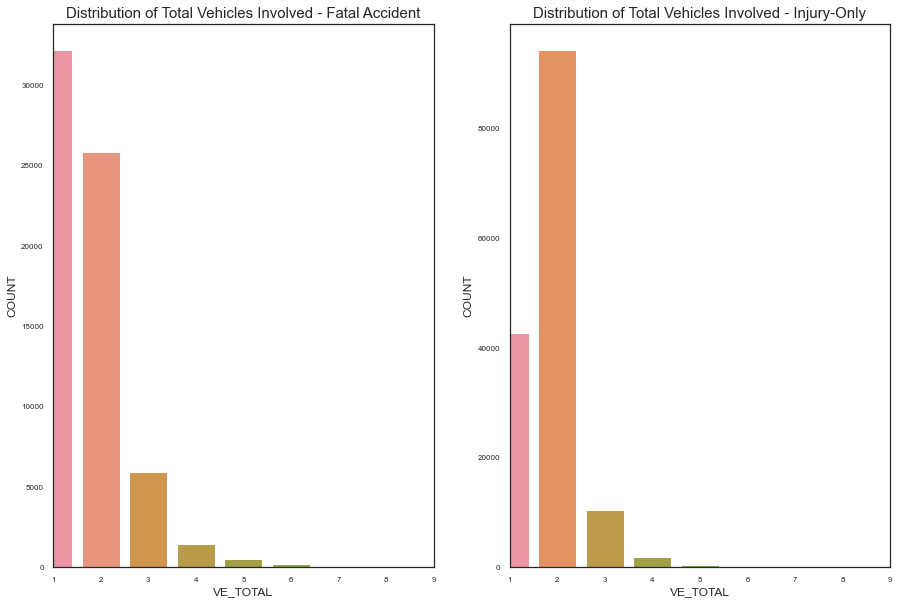

In [22]:
FARS_ve=FARS_ve.reset_index()
CRSS_ve=CRSS_ve.reset_index()

f,ax=plt.subplots(1,2,figsize=(15,10))
sns.set(font_scale=1)
rc={'font.size': 10, 'axes.labelsize': 12, 
    'axes.titlesize': 15, 'xtick.labelsize':10, 'ytick.labelsize': 10}
sns.set_context(rc=rc)
sns.set_style("white")
sns.barplot(x='VE_TOTAL',y='COUNT',ax=ax[0],data=FARS_ve)
#sns.histplot(FARS["VE_TOTAL"],ax=ax[0],binwidth=1)
ax[0].set_title('Distribution of Total Vehicles Involved - Fatal Accident')
ax[0].set(xlim=(0,8))
ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)

sns.barplot(x='VE_TOTAL',y='COUNT',ax=ax[1],data=CRSS_ve)
#sns.histplot(CRSS["VE_TOTAL"],ax=ax[1],binwidth=1)
ax[1].set_title('Distribution of Total Vehicles Involved - Injury-Only')
ax[1].set(xlim=(0,8))
    
plt.show()



##### As alcohol involvement is a critical factor for accident, let's compare it.
It's good that we see the majority in both fatal and injury-only accidents are non-alcohol involved.
However, if we compare fatal with injury-only, we could see that 37.42% of fatal accidents has at least 1 drunk driver involved.

In [23]:
#from IPython.display import display_html 
FARS_al=FARS.groupby(['DRUNK_DR'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_al=FARS_al.set_index(['DRUNK_DR'])
FARS_al["%"] = FARS_al.apply(lambda x:  100*x / x.sum())

CRSS_al=CRSS.groupby(['ALCOHOL'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_al=CRSS_al.set_index(['ALCOHOL'])
CRSS_al["%"] = CRSS_al.apply(lambda x:  100*x / x.sum())

FARS_al_styler = FARS_al.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_al_styler = CRSS_al.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_al_styler._repr_html_()+CRSS_al_styler._repr_html_(), raw=True)

Fatal-accident COUNT % DRUNK_DR 
 
 0 
 35018 
 62.585788 
 
 
 1 
 20128 
 35.973692 
 
 
 2 
 796 
 1.422648 
 
 
 3 
 9 
 0.016085 
 
 
 4 
 1 
 0.001787 
 
 Injury-Only accident COUNT % ALCOHOL 
 
 Alcohol Involved 
 7298 
 4.867832 
 
 
 No Alcohol Involved 
 121751 
 81.209021 
 
 
 No Applicable Person 
 76 
 0.050693 
 
 
 Unknown 
 20798 
 13.872455

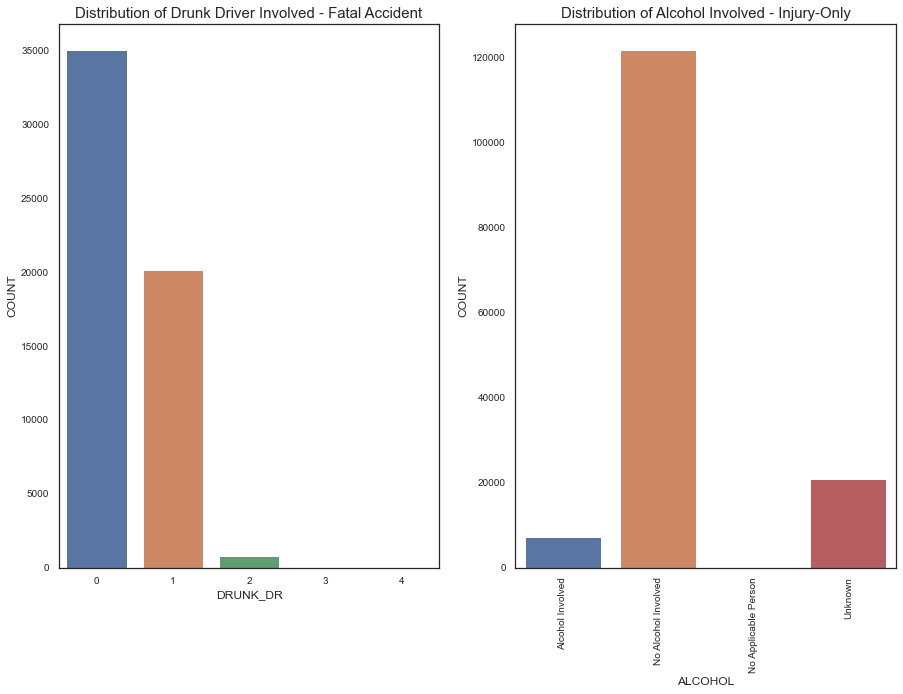

In [24]:
FARS_al=FARS_al.reset_index()
CRSS_al=CRSS_al.reset_index()

f,ax=plt.subplots(1,2,figsize=(15,10))
sns.set(font_scale=1)
rc={'font.size': 10, 'axes.labelsize': 12, 
    'axes.titlesize': 15, 'xtick.labelsize':10, 'ytick.labelsize': 10}
sns.set_context(rc=rc)
sns.set_style("white")
sns.barplot(x='DRUNK_DR',y='COUNT',ax=ax[0],data=FARS_al)
#sns.histplot(FARS["DRUNK_DR"],ax=ax[0],binwidth=1)
ax[0].set_title('Distribution of Drunk Driver Involved - Fatal Accident')
ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)


sns.barplot(x='ALCOHOL',y='COUNT',ax=ax[1],data=CRSS_al)
#sns.histplot(CRSS["ALCOHOL"],ax=ax[1],binwidth=2)
ax[1].set_title('Distribution of Alcohol Involved - Injury-Only')
plt.setp(ax[1].get_xticklabels(), rotation=90)


plt.show()

##### Now, let's see if weather will lead to more fatal accidents.
From the chart, we could see that the weather distribution is very identical between two type of accidents.
Thus, we may know that weather isn't a key factor that cause fatal accident.

In [25]:
FARS_w=FARS.groupby(['WEATHER'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_w=FARS_w.set_index(['WEATHER'])
FARS_w["%"] = FARS_w.apply(lambda x:  100*x / x.sum())

CRSS_w=CRSS.groupby(['WEATHER'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_w=CRSS_w.set_index(['WEATHER'])
CRSS_w["%"] = CRSS_w.apply(lambda x:  100*x / x.sum())

FARS_w_styler = FARS_w.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_w_styler = CRSS_w.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_w_styler._repr_html_()+CRSS_w_styler._repr_html_(), raw=True)

Fatal-accident COUNT % WEATHER 
 
 Blowing Sand, Soil, Dirt 
 37 
 0.062764 
 
 
 Blowing Snow 
 67 
 0.113654 
 
 
 Clear 
 33117 
 56.177164 
 
 
 Cloudy 
 12367 
 20.978440 
 
 
 Fog, Smog, Smoke 
 1143 
 1.938898 
 
 
 Freezing Rain or Drizzle 
 59 
 0.100083 
 
 
 Other 
 124 
 0.210344 
 
 
 Rain 
 6840 
 11.602857 
 
 
 Severe Crosswinds 
 161 
 0.273108 
 
 
 Sleet or Hail 
 178 
 0.301946 
 
 
 Snow 
 1013 
 1.718376 
 
 
 Unknown/Reported as Unknown 
 3845 
 6.522366 
 
 Injury-Only accident COUNT % WEATHER 
 
 Blowing Sand, Soil, Dirt 
 31 
 0.020677 
 
 
 Blowing Snow 
 67 
 0.044690 
 
 
 Clear 
 103800 
 69.235541 
 
 
 Cloudy 
 22080 
 14.727560 
 
 
 Fog, Smog, Smoke 
 611 
 0.407543 
 
 
 Freezing Rain or Drizzle 
 45 
 0.030015 
 
 
 Other 
 110 
 0.073371 
 
 
 Rain 
 13152 
 8.772503 
 
 
 Severe Crosswinds 
 100 
 0.066701 
 
 
 Sleet or Hail 
 286 
 0.190765 
 
 
 Snow 
 2772 
 1.848949 
 
 
 Unknown/Reported as Unknown 
 6869 
 4.581685

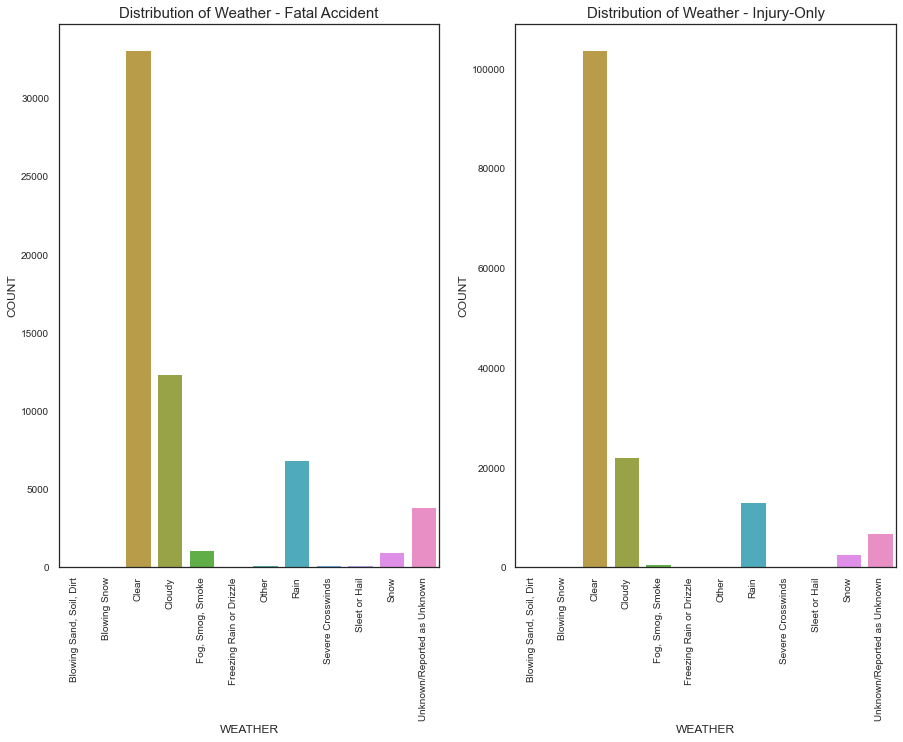

In [26]:
#FARS_sort = FARS.sort_values('WEATHER',ascending=True)
#CRSS_sort = CRSS.sort_values('WEATHER',ascending=True)
FARS_w=FARS_w.reset_index()
CRSS_w=CRSS_w.reset_index()

f,ax=plt.subplots(1,2,figsize=(15,10))
sns.set(font_scale=1)
rc={'font.size': 10, 'axes.labelsize': 12, 
    'axes.titlesize': 15, 'xtick.labelsize':8, 'ytick.labelsize': 8}
sns.set_context(rc=rc)
sns.set_style("white")
#FARS.dropna(subset=['WEATHER'],inplace = True)
#CRSS.dropna(subset=['WEATHER'],inplace = True)
sns.barplot(x='WEATHER',y='COUNT',ax=ax[0],data=FARS_w)
#sns.histplot(FARS_sort["WEATHER"],ax=ax[0])
ax[0].set_title('Distribution of Weather - Fatal Accident')
plt.setp(ax[0].get_xticklabels(), rotation=90)

sns.barplot(x='WEATHER',y='COUNT',ax=ax[1],data=CRSS_w)
#sns.histplot(CRSS_sort["WEATHER"],ax=ax[1])
ax[1].set_title('Distribution of Weather - Injury-Only')
plt.setp(ax[1].get_xticklabels(), rotation=90)
plt.show()

##### Next, we will take a look at how the collion manner different between both accidents.
What we have noticed that 48.5% of fatal accidents are 'Not Collision with Motor Vehicle in Transport' which aligns with what we have seen in the factor or single-vehicle/muti-vehicle.
Besides, we find out that more (14.00%) fatal accidents has front-to-front manner of collision compared to 3.7% injury-only accident. 


In [27]:
FARS_col=FARS.groupby(['MAN_COLL_x'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_col=FARS_col.set_index(['MAN_COLL_x'])
FARS_col["%"] = FARS_col.apply(lambda x:  100*x / x.sum())

CRSS_col=CRSS.groupby(['MAN_COLL_x'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_col=CRSS_col.set_index(['MAN_COLL_x'])
CRSS_col["%"] = CRSS_col.apply(lambda x:  100*x / x.sum())

FARS_col_styler = FARS_col.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_col_styler = CRSS_col.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_col_styler._repr_html_()+CRSS_col_styler._repr_html_(), raw=True)

Fatal-accident COUNT % MAN_COLL_x 
 
 Angle – Front-to-Side/Angle-Direction Not Specified 
 15557 
 22.646481 
 
 
 Front-to-Front 
 9620 
 14.003930 
 
 
 Front-to-Rear 
 6775 
 9.862435 
 
 
 Not Collision with Motor Vehicle in Transport 
 33291 
 48.462042 
 
 
 Not Reported 
 91 
 0.132470 
 
 
 Other (End-Swipes and Others) 
 275 
 0.400320 
 
 
 Rear-to-Rear 
 4 
 0.005823 
 
 
 Rear-to-Side 
 109 
 0.158672 
 
 
 Sideswipe – Opposite Direction 
 1193 
 1.736662 
 
 
 Sideswipe – Same Direction 
 1617 
 2.353883 
 
 
 Unknown/Reported as Unknown 
 163 
 0.237281 
 
 Injury-Only accident COUNT % MAN_COLL_x 
 
 Angle – Front-to-Side/Angle-Direction Not Specified 
 32157 
 21.449010 
 
 
 Front-to-Front 
 4729 
 3.154286 
 
 
 Front-to-Rear 
 45102 
 30.083443 
 
 
 Not Collision with Motor Vehicle in Transport 
 49768 
 33.195707 
 
 
 Not Reported 
 463 
 0.308825 
 
 
 Other (End-Swipes and Others) 
 919 
 0.612981 
 
 
 Rear-to-Rear 
 80 
 0.053361 
 
 
 Rear-to-Side 
 1046 
 0.697691 
 
 
 Sideswipe – Opposite Direction 
 2026 
 1.351360 
 
 
 Sideswipe – Same Direction 
 13382 
 8.925915 
 
 
 Unknown/Reported as Unknown 
 251 
 0.167419

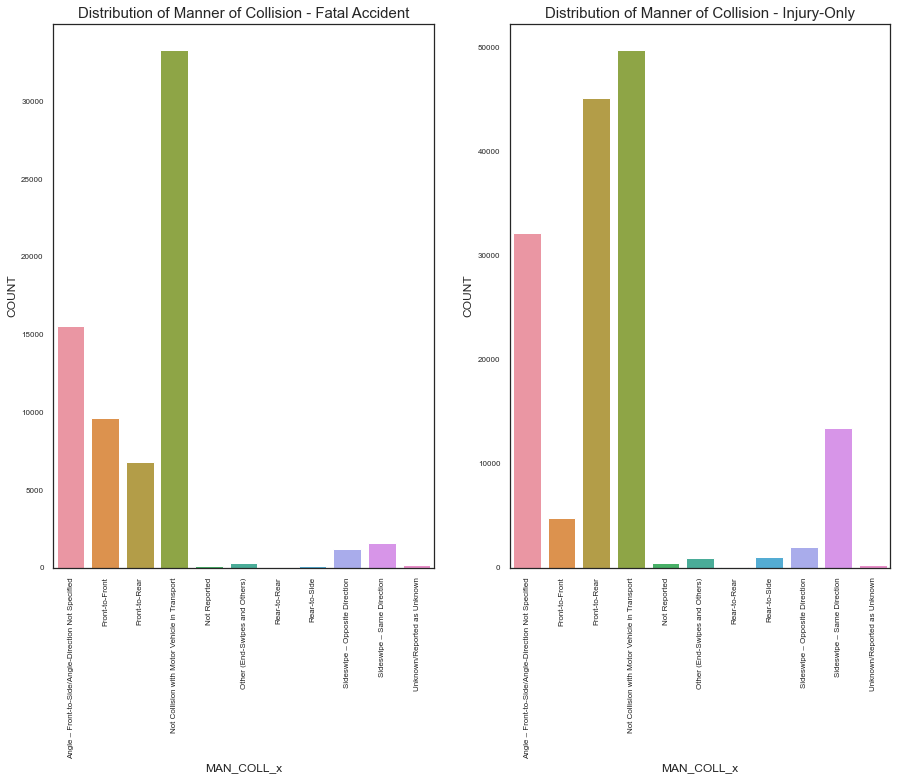

In [28]:
#FARS_sort = FARS.sort_values('MAN_COLL_x',ascending=True)
#CRSS_sort = CRSS.sort_values('MAN_COLL_x',ascending=True)
FARS_col=FARS_col.reset_index()
CRSS_col=CRSS_col.reset_index()

f,ax=plt.subplots(1,2,figsize=(15,10))
sns.set(font_scale=1)
rc={'font.size': 10, 'axes.labelsize': 12, 
    'axes.titlesize': 15, 'xtick.labelsize':8, 'ytick.labelsize': 8}
sns.set_context(rc=rc)
sns.set_style("white")
#FARS.dropna(subset=['WEATHER'],inplace = True)
#CRSS.dropna(subset=['WEATHER'],inplace = True)
sns.barplot(x='MAN_COLL_x',y='COUNT',ax=ax[0],data=FARS_col)
#sns.histplot(FARS_sort["MAN_COLL_x"],ax=ax[0])
ax[0].set_title('Distribution of Manner of Collision - Fatal Accident')
plt.setp(ax[0].get_xticklabels(), rotation=90)
ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)

sns.barplot(x='MAN_COLL_x',y='COUNT',ax=ax[1],data=CRSS_col)
#sns.histplot(CRSS_sort["MAN_COLL_x"],ax=ax[1])
ax[1].set_title('Distribution of Manner of Collision - Injury-Only')
plt.setp(ax[1].get_xticklabels(), rotation=90)
plt.show()

##### We are curious to see the position of the crash relates to the trafficway.
The Rel_road variable identifies the location of the crash as it relates to its position within or outside the trafficway.
Combine this information with the manner of collision, we could get more sense of how and where the collison happened in a traffic way.

When we compare both types of accidents, the majority happens 'On Roadway'.
What differs is more (19.81%) fatal accidents happen 'On Roadside' compared to 7.41% of injury-only accident. This further validates that single-vehicle or vehicle that is not in collision with another vehicle is more common in fatal accident.

In [29]:
FARS_rel=FARS.groupby(['REL_ROAD'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_rel=FARS_rel.set_index(['REL_ROAD'])
FARS_rel["%"] = FARS_rel.apply(lambda x:  100*x / x.sum())

CRSS_rel=CRSS.groupby(['REL_ROAD'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_rel=CRSS_rel.set_index(['REL_ROAD'])
CRSS_rel["%"] = CRSS_rel.apply(lambda x:  100*x / x.sum())

FARS_rel_styler = FARS_rel.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_rel_styler = CRSS_rel.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_rel_styler._repr_html_()+CRSS_rel_styler._repr_html_(), raw=True)

Fatal-accident COUNT % REL_ROAD 
 
 Continuous Left Turn Lane 
 91 
 0.140686 
 
 
 Gore 
 445 
 0.687971 
 
 
 In Parking Lane/Zone 
 245 
 0.378770 
 
 
 Not Reported 
 47 
 0.072662 
 
 
 Off Roadway – Location Unknown 
 338 
 0.522548 
 
 
 On Median 
 3761 
 5.814511 
 
 
 On Roadside 
 22122 
 34.200640 
 
 
 On Roadway 
 33281 
 51.452468 
 
 
 On Shoulder 
 1548 
 2.393210 
 
 
 Outside Trafficway 
 2319 
 3.585177 
 
 
 Separator 
 276 
 0.426696 
 
 
 Unknown/Reported as Unknown 
 210 
 0.324660 
 
 Injury-Only accident COUNT % REL_ROAD 
 
 Continuous Left Turn Lane 
 181 
 0.120729 
 
 
 Gore 
 252 
 0.168086 
 
 
 In Parking Lane/Zone 
 4281 
 2.855466 
 
 
 Not Reported 
 104 
 0.069369 
 
 
 Off Roadway – Location Unknown 
 396 
 0.264136 
 
 
 On Median 
 3019 
 2.013700 
 
 
 On Roadside 
 19261 
 12.847262 
 
 
 On Roadway 
 119990 
 80.034418 
 
 
 On Shoulder 
 1064 
 0.709698 
 
 
 Outside Trafficway 
 1262 
 0.841765 
 
 
 Separator 
 51 
 0.034017 
 
 
 Unknown/Reported as Unknown 
 62 
 0.041355

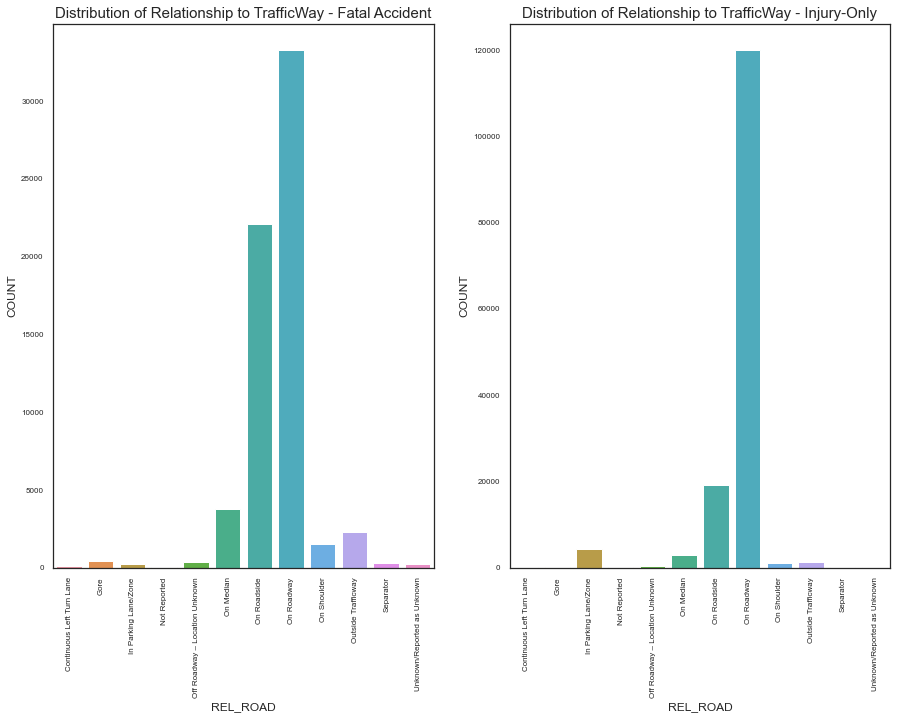

In [30]:
#FARS.dropna(subset=['REL_ROAD'],inplace = True)
#CRSS.dropna(subset=['REL_ROAD'],inplace = True)
#FARS_sort = FARS.sort_values('REL_ROAD',ascending=True)
#CRSS_sort = CRSS.sort_values('REL_ROAD',ascending=True)
FARS_rel=FARS_rel.reset_index()
CRSS_rel=CRSS_rel.reset_index()

f,ax=plt.subplots(1,2,figsize=(15,10))
sns.set(font_scale=1)
rc={'font.size': 10, 'axes.labelsize': 12, 
    'axes.titlesize': 15, 'xtick.labelsize':8, 'ytick.labelsize': 8}
sns.set_context(rc=rc)
sns.set_style("white")
ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)

#FARS.dropna(subset=['WEATHER'],inplace = True)
#CRSS.dropna(subset=['WEATHER'],inplace = True)

sns.barplot(x='REL_ROAD',y='COUNT',ax=ax[0],data=FARS_rel)
#sns.histplot(FARS_sort["REL_ROAD"],ax=ax[0])
ax[0].set_title('Distribution of Relationship to TrafficWay - Fatal Accident')
plt.setp(ax[0].get_xticklabels(), rotation=90)

sns.barplot(x='REL_ROAD',y='COUNT',ax=ax[1],data=CRSS_rel)
#sns.histplot(CRSS_sort["REL_ROAD"],ax=ax[1])
ax[1].set_title('Distribution of Relationship to TrafficWay - Injury-Only')
plt.setp(ax[1].get_xticklabels(), rotation=90)
plt.show()

##### According to WHO, accidents that involve hazardous material may lead to more fatal accidents.
Our dataset sample doesn't include much data records which has hazardous material involvement. But by quick check, we still see difference between fatal accidents and injury-only accident. Although we can't conclude that this factor plays large part, but 0.28% of our fatal-accidents records is hazardous material involved, while only 0.05% of our injury-only accidents are hazardous material involved.

In [31]:
FARS_haz=FARS.groupby(['HAZ_INV'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_haz=FARS_haz.set_index(['HAZ_INV'])
FARS_haz["%"] = FARS_haz.apply(lambda x:  100*x / x.sum())

CRSS_haz=CRSS.groupby(['HAZ_INV'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_haz=CRSS_haz.set_index(['HAZ_INV'])
CRSS_haz["%"] = CRSS_haz.apply(lambda x:  100*x / x.sum())

FARS_haz_styler = FARS_haz.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_haz_styler = CRSS_haz.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_haz_styler._repr_html_()+CRSS_haz_styler._repr_html_(), raw=True)

Fatal-accident COUNT % HAZ_INV 
 
 No 
 36174 
 98.803671 
 
 
 Yes 
 438 
 1.196329 
 
 Injury-Only accident COUNT % HAZ_INV 
 
 No 
 149895 
 99.912016 
 
 
 Yes 
 132 
 0.087984

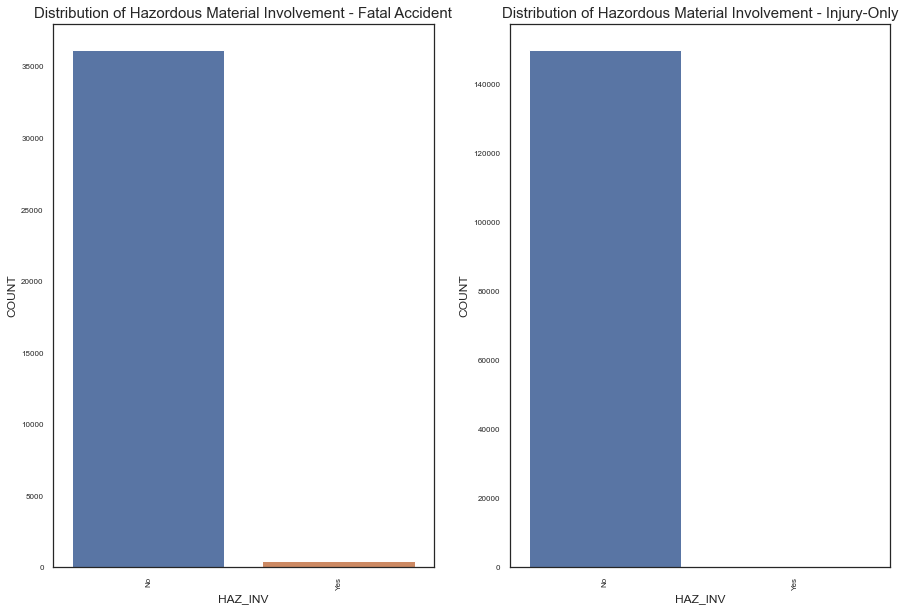

In [32]:
#FARS.dropna(subset=['HAZ_INV'],inplace = True)
#CRSS.dropna(subset=['HAZ_INV'],inplace = True)
FARS_haz=FARS_haz.reset_index()
CRSS_haz=CRSS_haz.reset_index()

f,ax=plt.subplots(1,2,figsize=(15,10))
sns.set(font_scale=1)
rc={'font.size': 10, 'axes.labelsize': 12, 
    'axes.titlesize': 15, 'xtick.labelsize':8, 'ytick.labelsize': 8}
sns.set_context(rc=rc)
sns.set_style("white")
#FARS.dropna(subset=['WEATHER'],inplace = True)
#CRSS.dropna(subset=['WEATHER'],inplace = True)
ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)

sns.barplot(x='HAZ_INV',y='COUNT',ax=ax[0],data=FARS_haz)
#sns.histplot(FARS["HAZ_INV"],ax=ax[0])
ax[0].set_title('Distribution of Hazordous Material Involvement - Fatal Accident')
plt.setp(ax[0].get_xticklabels(), rotation=90)

sns.barplot(x='HAZ_INV',y='COUNT',ax=ax[1],data=CRSS_haz)
#sns.histplot(CRSS["HAZ_INV"],ax=ax[1])
ax[1].set_title('Distribution of Hazordous Material Involvement - Injury-Only')
plt.setp(ax[1].get_xticklabels(), rotation=90)
plt.show()

##### Another Important thing to check is whether a rollover is involved in an accident.
It is clear that more rollover occur in fatal accidents which does make sense.

In [33]:
FARS_roll=FARS.groupby(['ROLLOVER'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_roll=FARS_roll.set_index(['ROLLOVER'])
FARS_roll["%"] = FARS_roll.apply(lambda x:  100*x / x.sum())

CRSS_roll=CRSS.groupby(['ROLLOVER'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_roll=CRSS_roll.set_index(['ROLLOVER'])
CRSS_roll["%"] = CRSS_roll.apply(lambda x:  100*x / x.sum())

FARS_roll_styler = FARS_roll.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_roll_styler = CRSS_roll.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_roll_styler._repr_html_()+CRSS_roll_styler._repr_html_(), raw=True)

Fatal-accident COUNT % ROLLOVER 
 
 No Rollover 
 35661 
 64.057841 
 
 
 Rollover, Tripped by Object/Vehicle Subsequent Event 
 15651 
 28.113885 
 
 
 Rollover, Unknown Type 
 1203 
 2.160948 
 
 
 Rollover, Untripped 
 3155 
 5.667325 
 
 Injury-Only accident COUNT % ROLLOVER 
 
 No Rollover 
 144541 
 95.233107 
 
 
 Rollover, Tripped by Object/Vehicle Subsequent Event 
 2468 
 1.626081 
 
 
 Rollover, Unknown Type 
 4274 
 2.815992 
 
 
 Rollover, Untripped 
 493 
 0.324821

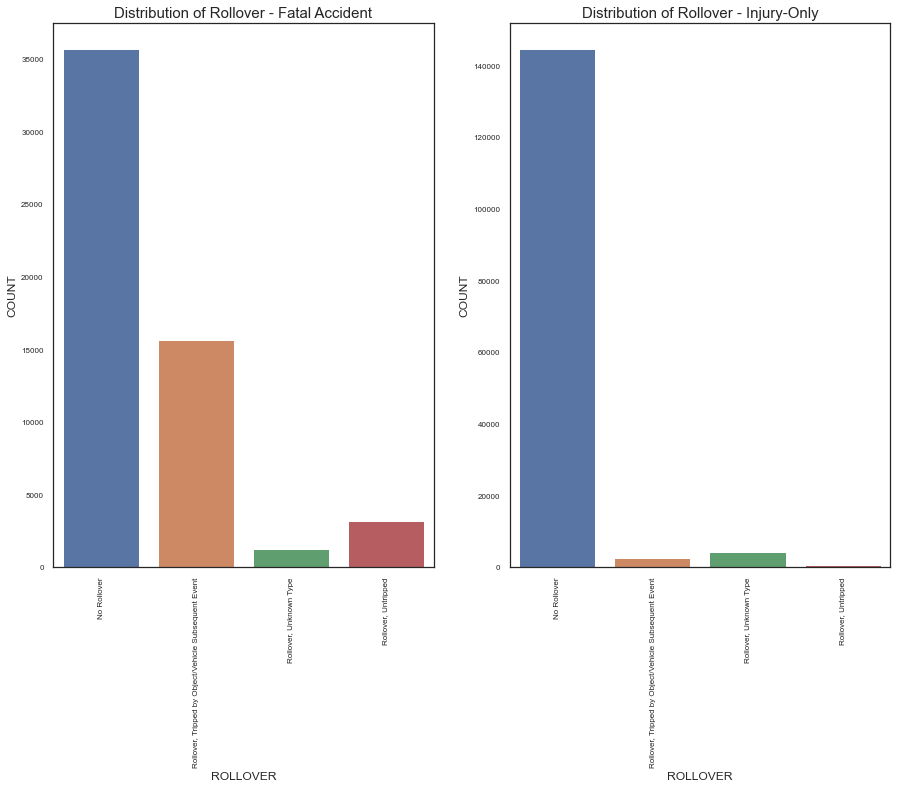

In [34]:
#FARS_sort = FARS.sort_values('ROLLOVER',ascending=True)
#CRSS_sort = CRSS.sort_values('ROLLOVER',ascending=True)
FARS_roll=FARS_roll.reset_index()
CRSS_roll=CRSS_roll.reset_index()

f,ax=plt.subplots(1,2,figsize=(15,10))
sns.set(font_scale=1)
rc={'font.size': 10, 'axes.labelsize': 12, 
    'axes.titlesize': 15, 'xtick.labelsize':8, 'ytick.labelsize': 8}
sns.set_context(rc=rc)
sns.set_style("white")

sns.barplot(x='ROLLOVER',y='COUNT',ax=ax[0],data=FARS_roll)
#sns.histplot(FARS_sort["ROLLOVER"],ax=ax[0])
#sns.displot(FARS_sort,x="ROLLOVER",ax=axes[0], hue="DR_DRINK")
ax[0].set_title('Distribution of Rollover - Fatal Accident')
plt.setp(ax[0].get_xticklabels(), rotation=90)
ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)


sns.barplot(x='ROLLOVER',y='COUNT',ax=ax[1],data=CRSS_roll)
#sns.histplot(CRSS_sort["ROLLOVER"],ax=ax[1])
#sns.displot(CRSS_sort,x="ROLLOVER",ax=axes[1], hue="ALCOHOL")
ax[1].set_title('Distribution of Rollover - Injury-Only')
plt.setp(ax[1].get_xticklabels(), rotation=90)
plt.show()

##### One last factor to compare is if fire occured in an accident in a vehicle.
It is obvious that more fatal accidents have fire occurrence.

In [35]:
FARS_fire=FARS.groupby(['FIRE_EXP'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_fire=FARS_fire.set_index(['FIRE_EXP'])
FARS_fire["%"] = FARS_fire.apply(lambda x:  100*x / x.sum())

CRSS_fire=CRSS.groupby(['FIRE_EXP'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_fire=CRSS_fire.set_index(['FIRE_EXP'])
CRSS_fire["%"] = CRSS_fire.apply(lambda x:  100*x / x.sum())

FARS_fire_styler = FARS_fire.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_fire_styler = CRSS_fire.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_fire_styler._repr_html_()+CRSS_fire_styler._repr_html_(), raw=True)

Fatal-accident COUNT % FIRE_EXP 
 
 No or Not Reported 
 36155 
 89.194523 
 
 
 Yes 
 4380 
 10.805477 
 
 Injury-Only accident COUNT % FIRE_EXP 
 
 No or Not Reported 
 149612 
 99.682853 
 
 
 Yes 
 476 
 0.317147

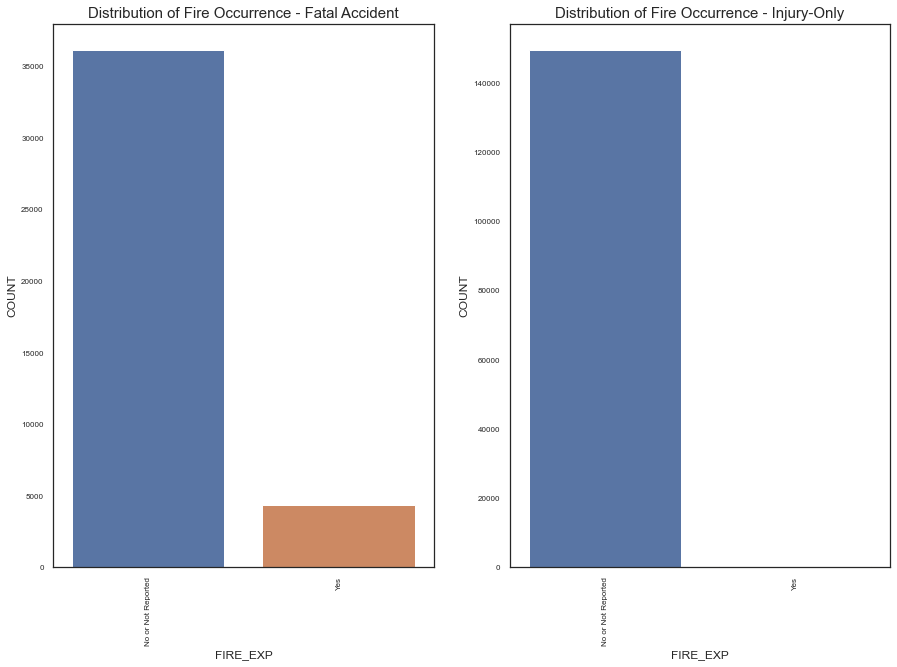

In [36]:
FARS_fire=FARS_fire.reset_index()
CRSS_fire=CRSS_fire.reset_index()

f,ax=plt.subplots(1,2,figsize=(15,10))
sns.set(font_scale=1)
rc={'font.size': 10, 'axes.labelsize': 12, 
    'axes.titlesize': 15, 'xtick.labelsize':8, 'ytick.labelsize': 8}
sns.set_context(rc=rc)
sns.set_style("white")

sns.barplot(x='FIRE_EXP',y='COUNT',ax=ax[0],data=FARS_fire)
#sns.histplot(FARS["FIRE_EXP"],ax=ax[0])
#sns.displot(FARS_sort,x="ROLLOVER",ax=axes[0], hue="DR_DRINK")
ax[0].set_title('Distribution of Fire Occurrence - Fatal Accident')
plt.setp(ax[0].get_xticklabels(), rotation=90)
ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)

sns.barplot(x='FIRE_EXP',y='COUNT',ax=ax[1],data=CRSS_fire)
#sns.histplot(CRSS["FIRE_EXP"],ax=ax[1])
#sns.displot(CRSS_sort,x="ROLLOVER",ax=axes[1], hue="ALCOHOL")
ax[1].set_title('Distribution of Fire Occurrence - Injury-Only')
plt.setp(ax[1].get_xticklabels(), rotation=90)
plt.show()

### Now, we will focus more on fatal-crash and find if there's any patterns among this type of accident.

##### Let's first take a look at hours that most fatal crash accident happen.
From the combo chart below, we are able to find out that fatal accidents also follow peak hours.
While the bars are showing number of fatals by hours which are very identical among hours.
However, we could notice that drunk driver involved fatal accidents increases in the evening and reaches the top at 2 o'clock.

In [37]:
FARS_hour = FARS[FARS['HOUR_x']<99]
FARS_hour2=FARS_hour.groupby(['HOUR_x','DR_DRINK'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})

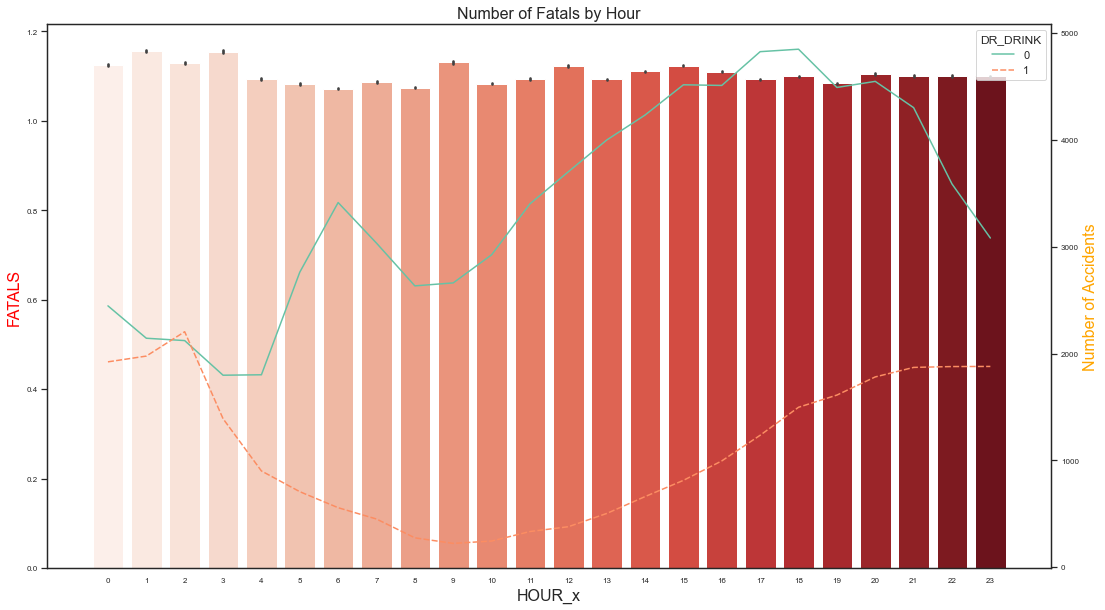

In [38]:
fig, ax1 = plt.subplots(figsize=(18,10))
color = 'tab:green'
#bar plot creation
ax1.set_title('Number of Fatals by Hour', fontsize=16)
ax1.set_xlabel('HOUR_x', fontsize=16)
ax1.set_ylabel('Number of Fatals', fontsize=16,color='red')
ax1 = sns.barplot(data=FARS_hour, x='HOUR_x',y='FATALS',palette='Reds')
ax1.tick_params(axis='y')
ax1.grid(False)

ax2 = ax1.twinx()
#color = 'tab:red'
#line plot creation
ax2.set_ylabel('Number of Accidents', fontsize=16,color='Orange')
ax2 = sns.lineplot(data=FARS_hour2, x='HOUR_x',y='COUNT',hue='DR_DRINK',style='DR_DRINK',palette="Set2")
ax2.tick_params(axis='y')
ax2.grid(False)
#show plot
plt.show()

##### Now, let's look at the relationship between number of vehicle involves vs damage level of vehicles.
From the heatmap, we could see that single vehicle accidents have most cases in 'disabling damage' for fatal accidents which align with our findings in previous section.

In [39]:
heatmap_dam_ve=FARS.groupby(['DEFORMED','VE_TOTAL'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})


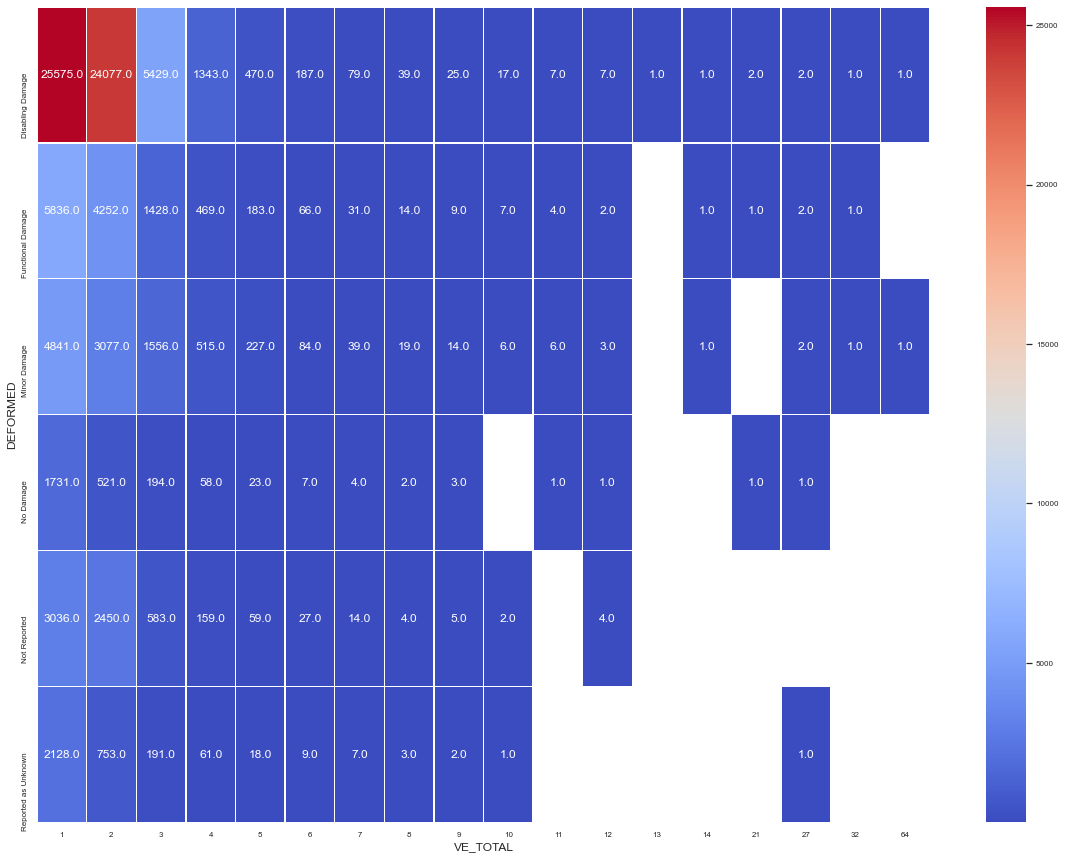

In [40]:
fig, ax = plt.subplots(figsize=(20,15))         # Sample figsize in inches

heatmap_dam_ve_2 = pd.pivot_table(data=heatmap_dam_ve,
                    index='DEFORMED',
                    values='COUNT',
                    columns='VE_TOTAL')
sns.heatmap(heatmap_dam_ve_2,cmap='coolwarm',annot=True,fmt=".1f",annot_kws={'size':12},linewidths=.5, ax=ax)
plt.show()

##### Let's see if speeding is directly related to fatal accident.
Speed_rel records whether the driver's speed was related to the crash as indicated by law enforcement.

So we can see that 21.31% of fatal accidents is directly related to speeding. Among which, 6.9% exceeded speed limit and 7.6% is too fast for conditions. This implies that speeding is one of the major reason leads to fatal accident. Although we have educated drivers not to exceed speed limit and drive not too fast, there are still lots of space to improve.

In [41]:
Speed_rel={0:"No", 2:"Yes, Racing", 3:"Yes, Exceeded Speed Limit", 
         4:"Yes, Too Fast for Conditions", 5:"Yes, Specifics Unknown",
           8:"No Driver Present/Unknown if Driver Present",
     9:"Reported as Unknown"
        }

FARS=FARS.replace({"SPEEDREL": Speed_rel})



conditions = [
    (FARS['SPEEDREL'] == 'Yes, Racing') | (FARS['SPEEDREL'] == 'Yes, Exceeded Speed Limit')|(FARS['SPEEDREL'] == 'Yes, Too Fast for Conditions')
    |(FARS['SPEEDREL'] == 'Yes, Specifics Unknown')
    ,(FARS['SPEEDREL'] == 'No')| (FARS['SPEEDREL'] == 'No Driver Present/Unknown if Driver Present'),
 (FARS['SPEEDREL'] == 'Reported as Unknown')]
choices = ['Yes, speed related crash', 'No','Unknown']
FARS['SPEEDREL_BIN'] = np.select(conditions, choices, default='Unknown')

In [42]:
FARS_sp=FARS.groupby(['SPEEDREL'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_sp=FARS_sp.set_index(['SPEEDREL'])
FARS_sp["%"] = FARS_sp.apply(lambda x:  100*x / x.sum())

CRSS_sp=CRSS.groupby(['SPEEDREL'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_sp=CRSS_sp.set_index(['SPEEDREL'])
CRSS_sp["%"] = CRSS_sp.apply(lambda x:  100*x / x.sum())

FARS_sp_styler = FARS_sp.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_sp_styler = CRSS_sp.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_sp_styler._repr_html_()+CRSS_sp_styler._repr_html_(), raw=True)

Fatal-accident COUNT % SPEEDREL 
 
 No 
 35297 
 54.919869 
 
 
 No Driver Present/Unknown if Driver Present 
 837 
 1.302318 
 
 
 Reported as Unknown 
 5039 
 7.840361 
 
 
 Yes, Exceeded Speed Limit 
 9341 
 14.533997 
 
 
 Yes, Racing 
 213 
 0.331414 
 
 
 Yes, Specifics Unknown 
 3421 
 5.322857 
 
 
 Yes, Too Fast for Conditions 
 10122 
 15.749183 
 
 Injury-Only accident COUNT % SPEEDREL 
 
 0 
 140087 
 85.683267 
 
 
 2 
 34 
 0.020796 
 
 
 3 
 1858 
 1.136433 
 
 
 4 
 11942 
 7.304244 
 
 
 5 
 2183 
 1.335217 
 
 
 8 
 530 
 0.324171 
 
 
 9 
 6860 
 4.195873

##### We already know that speed is critical factor, and let's combine it with the level of damage of vehicles.
From the box plot, we can confirm that the level of damage is more severe as travelling speed increases.
We have further categorize the accident based on speed_rel and the color grey marks the accident which is speed related according to law enforcement. 
We could see that in the most severe damage 'Disabling damage', the overall travelling speed is higher compared to the other level of damage. And at the same time, the 'speed related crash' has the highest median speed at 70 mph.
From this plot, we could learn that speed is also directly related to vehicle level of damage.

In [43]:
Fars_dedup=FARS.drop_duplicates(['ST_CASE','DEFORMED','SPEEDREL_BIN','TRAV_SP'])[['ST_CASE','DEFORMED','SPEEDREL_BIN','TRAV_SP']]

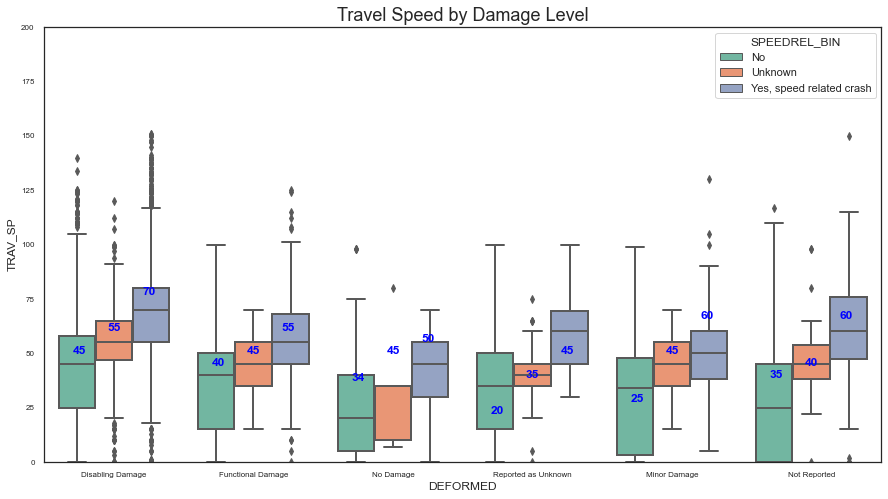

In [44]:
FARS_Trv_sp = Fars_dedup[Fars_dedup['TRAV_SP']<997]
FARS_Trv_sp = FARS_Trv_sp.sort_values('SPEEDREL_BIN',ascending=True)
plt.figure(figsize=(15,8))
ax=sns.boxplot(x = 'DEFORMED', y = 'TRAV_SP', hue="SPEEDREL_BIN", data = FARS_Trv_sp,linewidth=2,fliersize=5,palette="Set2") 
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.set(font_scale =1)
ax.set(ylim=(0, 200))
ax.set_title('Travel Speed by Damage Level',fontsize=18)
sns.set_style("white")

#Let's show the median values in the plot.
m1 = FARS_Trv_sp.groupby(['DEFORMED',"SPEEDREL_BIN"])['TRAV_SP'].median().values
mL1 = [str(np.round(s, 2)) for s in m1]


ind = 0
for tick in range(len(ax.get_xticklabels())):
    ax.text(tick, m1[ind+1]+m1[ind+1]*0.1, mL1[ind+1],  horizontalalignment='center', size='medium', color='blue', weight='bold')
    ax.text(tick+0.25, m1[ind+2]+m1[ind+2]*0.1, mL1[ind+2],  horizontalalignment='center', size='medium', color='blue', weight='bold')
    ax.text(tick-0.25, m1[ind]+m1[ind]*0.1, mL1[ind], horizontalalignment='center', size='medium',color='blue', weight='bold')
    ind += 3 

plt.show()


##### Let's take a further look and see if surface type and surface conditions plays a role in fatal accident.
From the heatmap below, we could see that the majority of accidents occur on 'Blacktop, Bituminous, or Saphalt' when it is 'dry', the other surface condition that has slightly more fatal accidents is 'wet'. But this is mostly due to these two conditions are more likely to occur among all seasons.

In [45]:
heatmap_surface=FARS.groupby(['VPAVETYP','VSURCOND'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})

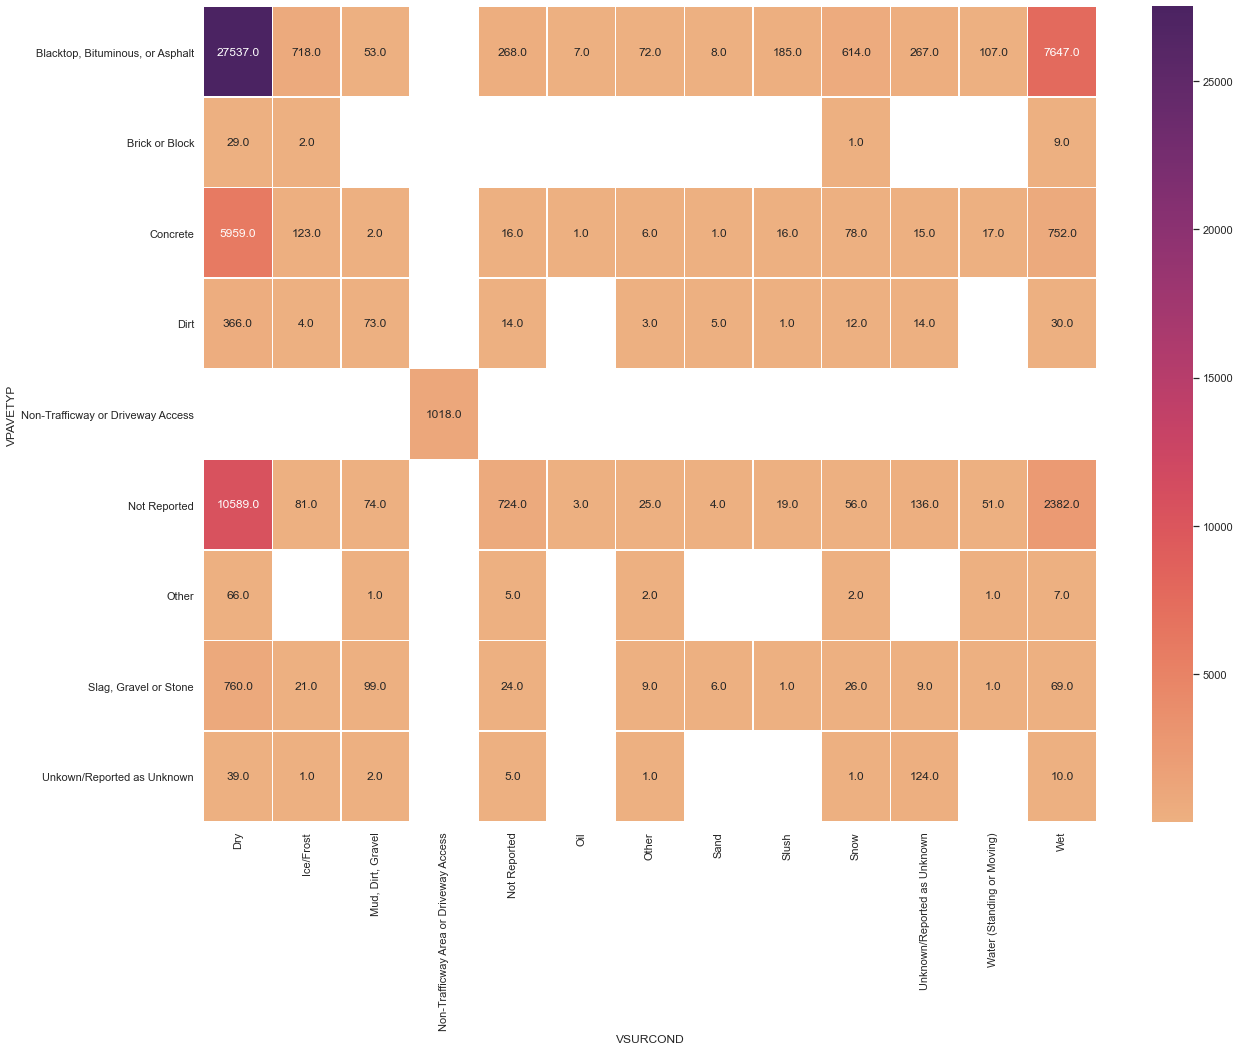

In [46]:
fig, ax = plt.subplots(figsize=(20,15))         # Sample figsize in inches

heatmap_surface_2 = pd.pivot_table(data=heatmap_surface,
                    index='VPAVETYP',
                    values='COUNT',
                    columns='VSURCOND')
sns.heatmap(heatmap_surface_2,cmap='flare',annot=True,fmt=".1f",annot_kws={'size':12},linewidths=.5, ax=ax)
plt.show()

##### Finally, let's take a look at the body type, make in fatal accidents and combine the level of damage. 
So we can see that 

In [47]:
FARS_VEHICLE=FARS.groupby(['BODY_TYP'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_VEHICLE_sort =FARS_VEHICLE.sort_values('COUNT',ascending=False)
FARS_VEHICLE_TOP20=FARS_VEHICLE_sort.head(20)
FARS_VEHICLE_TOP20

BODY_TYP  COUNT
4                                4-Door Sedan/Hardtop  26536
12  Compact Utility (ANSI D-16 Utility Vehicle Cat...  15335
23                                       Light Pickup  14202
55    Two Wheel Motorcycle (excluding motor scooters)  12087
54  Truck/Tractor (Cab Only, or with Any Number of...   7363
47   Standard Pickup (4,500 lbs <= GVWR < 10,000 lbs)   6533
21  Large Utility (ANSI D-16 Utility Vehicle Categ...   5809
1                          2-Door Sedan/Hardtop/Coupe   5795
48      Station Wagon (Excluding Van and Truck-Based)   5214
27                                            Minivan   4500
5                             5-Door/4-Door Hatchback   2620
58                                  Unknown Body Type   2404
43  Single-Unit Straight Truck or Cab-Chassis (GVW...   1770
22               Large Van – Includes Van-Based Buses   1742
3                             3-Door/2-Door Hatchback   1700
11                 Compact Pickup (GVWR, < 4,500 lbs)   1695
25  Medium/Heavy Pickup (GVWR > 10,000 lbs) (Since...   1180
14              Convertible (Excludes Sunroof, T-Bar)   1127
44  Single-Unit Straight Truck or Cab-Chassis (GVW...   1116
6   ATV (All-Terrain Vehicle; Includes 3 or 4 Wheels)    932

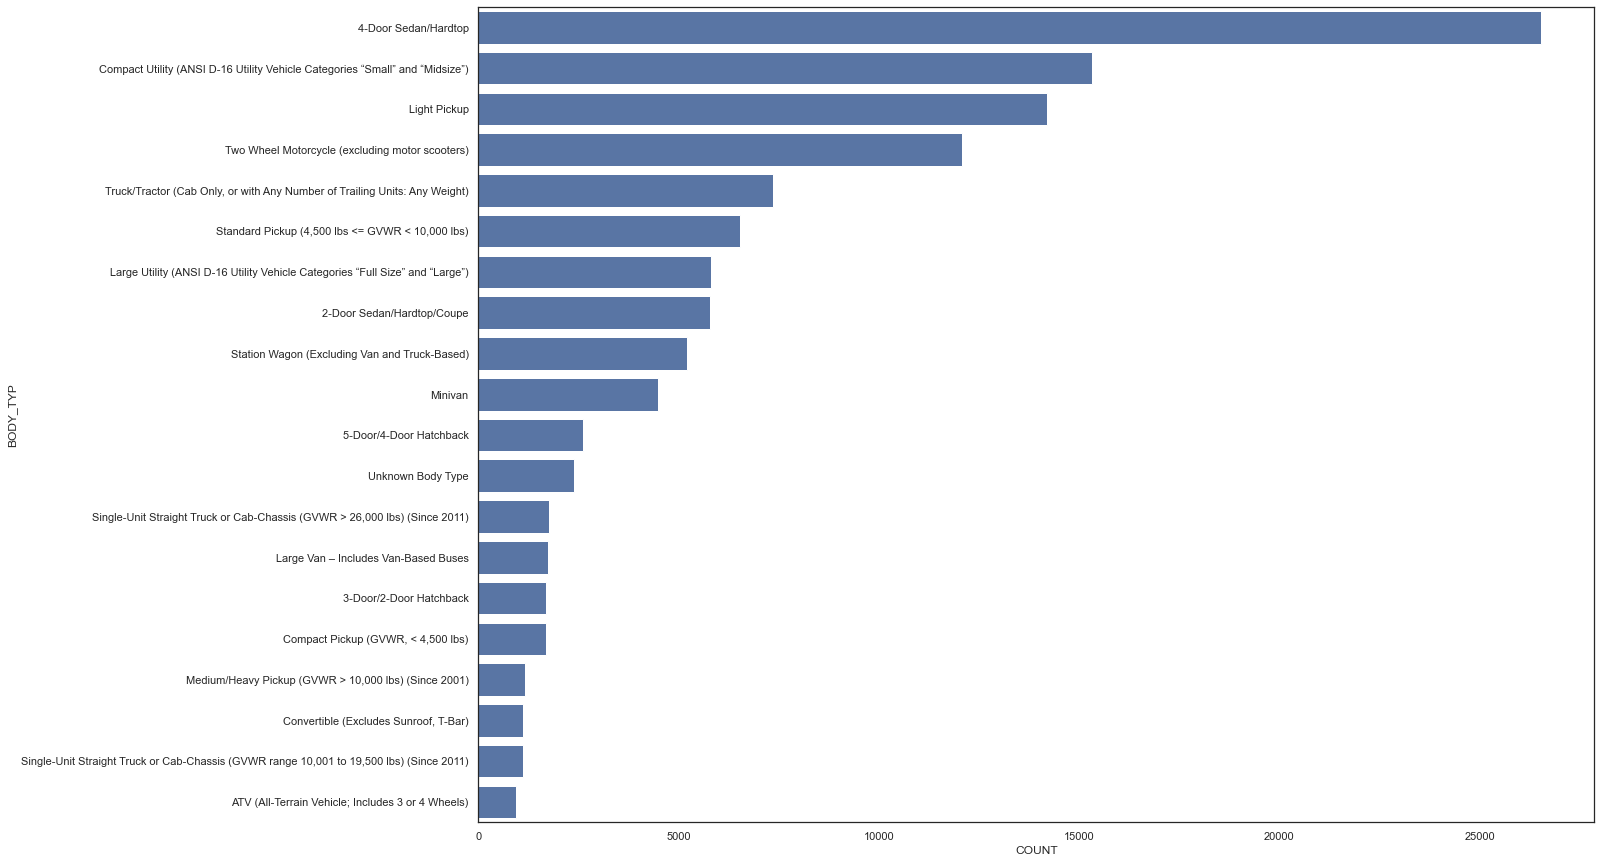

In [48]:
fig, ax = plt.subplots(figsize=(20,15))  
sns.barplot(x = 'COUNT', y = 'BODY_TYP',data = FARS_VEHICLE_TOP20,
             color = 'b', edgecolor = 'w')
plt.show()

In [49]:
FARS_VEHICLE_m_t=FARS.groupby(['BODY_TYP','MAKE','DEFORMED'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_VEHICLE_m_t_sort =FARS_VEHICLE_m_t.sort_values('COUNT',ascending=False)
FARS_VEHICLE_m_t_sort_TOP30=FARS_VEHICLE_m_t_sort.head(30)
FARS_VEHICLE_m_t_sort_TOP30

BODY_TYP                          MAKE             DEFORMED  COUNT
424                                4-Door Sedan/Hardtop                        Toyota     Disabling Damage   4216
279                                4-Door Sedan/Hardtop                     Chevrolet     Disabling Damage   4041
1223                                       Light Pickup                          Ford     Disabling Damage   4001
2325    Two Wheel Motorcycle (excluding motor scooters)               Harley-Davidson     Disabling Damage   3945
1205                                       Light Pickup                     Chevrolet     Disabling Damage   3678
312                                4-Door Sedan/Hardtop                         Honda     Disabling Damage   3376
293                                4-Door Sedan/Hardtop                 Datsun/Nissan     Disabling Damage   3168
306                                4-Door Sedan/Hardtop                          Ford     Disabling Damage   3119
767   Compact Utility (ANSI D-16 Utility Vehicle Cat...  Jeep/Kaiser-Jeep/Willys Jeep     Disabling Damage   2600
731   Compact Utility (ANSI D-16 Utility Vehicle Cat...                          Ford     Disabling Damage   2438
1217                                       Light Pickup                         Dodge     Disabling Damage   2161
2263  Truck/Tractor (Cab Only, or with Any Number of...                  Freightliner     Disabling Damage   1847
708   Compact Utility (ANSI D-16 Utility Vehicle Cat...                     Chevrolet     Disabling Damage   1802
318                                4-Door Sedan/Hardtop                       Hyundai     Disabling Damage   1793
2456                                  Unknown Body Type                  Unknown Make  Reported as Unknown   1763
2331    Two Wheel Motorcycle (excluding motor scooters)                         Honda     Disabling Damage   1751
1996   Standard Pickup (4,500 lbs <= GVWR < 10,000 lbs)                     Chevrolet     Disabling Damage   1635
2012   Standard Pickup (4,500 lbs <= GVWR < 10,000 lbs)                          Ford     Disabling Damage   1632
267                                4-Door Sedan/Hardtop                    Buick/Opel     Disabling Damage   1542
2352    Two Wheel Motorcycle (excluding motor scooters)                        Suzuki     Disabling Damage   1503
853   Compact Utility (ANSI D-16 Utility Vehicle Cat...                        Toyota     Disabling Damage   1485
2373    Two Wheel Motorcycle (excluding motor scooters)                        Yamaha     Disabling Damage   1464
1063  Large Utility (ANSI D-16 Utility Vehicle Categ...                     Chevrolet     Disabling Damage   1459
299                                4-Door Sedan/Hardtop                         Dodge     Disabling Damage   1276
2337    Two Wheel Motorcycle (excluding motor scooters)                      Kawasaki     Disabling Damage   1261
1229                                       Light Pickup                           GMC     Disabling Damage   1151
37                           2-Door Sedan/Hardtop/Coupe                     Chevrolet     Disabling Damage   1128
395                                4-Door Sedan/Hardtop                       Pontiac     Disabling Damage   1078
68                           2-Door Sedan/Hardtop/Coupe                         Honda     Disabling Damage   1021
1255                                       Light Pickup                        Toyota     Disabling Damage   1019

In [50]:
import plotly.express as px 
fig = px.sunburst(FARS_VEHICLE_m_t_sort_TOP30, path=['BODY_TYP', 'MAKE'],  
                  values='COUNT',color='COUNT') 
fig.show()

### Now, let's take a look at cities with high cyclists involved fatal accidents.

In [51]:
top_cities['City'] = top_cities['City'].str.upper() 
top_cities['State[c]'] = top_cities['State[c]'].str.upper() 

In [69]:
FARS['Bike_IND'] = np.where((FARS['PBPTYPE']==6)|(FARS['PBPTYPE']==7), "Yes", "No")

FARS_bk=FARS.groupby(['Bike_IND','State Name','City Name'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_bk_inv=FARS_bk[FARS_bk['Bike_IND']=='Yes']
FARS_bk_inv.drop(['Bike_IND'],axis=1,inplace=True)
FARS_bk_inv.sort_values('COUNT',ascending=False).head(10)
FARS_bk_inv=FARS_bk_inv.set_index(['State Name','City Name'])

FARS_bk_inv["%"] = FARS_bk_inv.apply(lambda x:  100*x / x.sum())
FARS_bk_inv

COUNT         %
State Name City Name                    
ALABAMA    ATHENS            1  0.060241
           BIRMINGHAM        2  0.120482
           DOTHAN            1  0.060241
           JACKSON           1  0.060241
           MOBILE            2  0.120482
...                        ...       ...
WISCONSIN  NEENAH            1  0.060241
           NEW RICHMOND      1  0.060241
           OSHKOSH           1  0.060241
           PEWAUKEE          2  0.120482
WYOMING    CHEYENNE          1  0.060241

[895 rows x 2 columns]

In [71]:
FARS_bk_inv=FARS_bk_inv.reset_index()
FARS_bk_TOP10=FARS_bk_inv.sort_values('%',ascending=False).head(10)

In [72]:
FARS_bk_TOP10_Popu=pd.merge(FARS_bk_TOP10, top_cities[['City','State[c]','2010Census','2016 land area','2016 population density']],  how='left', left_on=['City Name','State Name'], right_on = ['City','State[c]'])

In [73]:
FARS_bk_TOP10_Popu

State Name      City Name  COUNT         %           City    State[c]  2010Census 2016 land area 2016 population density
0  CALIFORNIA    LOS ANGELES     56  3.373494    LOS ANGELES  CALIFORNIA   3792621.0    468.7 sq mi             8,484/sq mi
1    NEW YORK  NEW YORK CITY     29  1.746988  NEW YORK CITY    NEW YORK   8175133.0    301.5 sq mi            28,317/sq mi
2     ARIZONA        PHOENIX     24  1.445783        PHOENIX     ARIZONA   1445632.0    517.6 sq mi             3,120/sq mi
3       TEXAS        HOUSTON     21  1.265060        HOUSTON       TEXAS   2100263.0    637.5 sq mi             3,613/sq mi
4  CALIFORNIA     SACRAMENTO     20  1.204819     SACRAMENTO  CALIFORNIA    466488.0     97.9 sq mi             5,059/sq mi
5     FLORIDA   JACKSONVILLE     20  1.204819   JACKSONVILLE     FLORIDA    821784.0    747.4 sq mi             1,178/sq mi
6    ILLINOIS        CHICAGO     17  1.024096        CHICAGO    ILLINOIS   2695598.0    227.3 sq mi            11,900/sq mi
7  CALIFORNIA       STOCKTON     16  0.963855       STOCKTON  CALIFORNIA    291707.0     61.7 sq mi             4,977/sq mi
8  CALIFORNIA       SAN JOSE     13  0.783133       SAN JOSE  CALIFORNIA    945942.0    177.5 sq mi             5,777/sq mi
9    NEW YORK       NEW YORK     13  0.783133            NaN         NaN         NaN            NaN                     NaN

In [75]:
bike_only=FARS[FARS['Bike_IND']=='Yes']
PB_Popu=pd.merge(bike_only, top_cities[['City','State[c]','2016 land area','2010Census','2016 population density']],  how='left', left_on=['City Name','State Name'], right_on = ['City','State[c]'])

In [78]:
PB_Popu_6state=PB_Popu[PB_Popu['State Name'].isin(['CALIFORNIA', 'ARIZONA','TEXAS','NEW YORK','ILLINOIS','FLORIDA'])]

In [79]:
PB_Popu_10cities=PB_Popu_6state[PB_Popu_6state['City Name'].isin(['LOS ANGELES','PHOENIX','HOUSTON','NEW YORK CITY','SACRAMENTO','STOCKTON','CHICAGO','JACKSONVILLE','NEW YORK','SAN JOSE'])]

In [80]:
Bike_loc={1:"At Intersection", 2:"Intersection-Related", 
         3:"Not At Intersection", 4:"Non-Trafficway Location",
           7:"Not a Cyclist",
     9:"Unknown/Insufficient Information"
        }

FARS=FARS.replace({"BIKELOC": Bike_loc})


Bike_pos={1:"Travel Lane", 2:"Bicycle Lane/Paved Shoulder/Parking Lane", 
         3:"Sidewalk/Crosswalk/Driveway Access", 4:"Shared-Use Path",
          5:"Non-Trafficway – Driveway",6:"Non-Trafficway – Parking Lot/Other",
           7:"Not a Cyclist",8:"Other",
     9:"Unknown"
        }


PB_Popu_10cities=PB_Popu_10cities.replace({"BIKELOC": Bike_loc})
PB_Popu_10cities=PB_Popu_10cities.replace({"BIKEPOS": Bike_pos})

PB_BIKE=PB_Popu_10cities.groupby(['City Name','BIKEPOS','BIKELOC'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
PB_BIKE_SORT =PB_BIKE.sort_values('COUNT',ascending=False)
PB_BIKE_SORT.head(30)


City Name                                   BIKEPOS                           BIKELOC  COUNT
23    LOS ANGELES                               Travel Lane               Not At Intersection     26
36  NEW YORK CITY                               Travel Lane                   At Intersection     15
44        PHOENIX                               Travel Lane               Not At Intersection     13
9         HOUSTON                               Travel Lane               Not At Intersection     12
21    LOS ANGELES                               Travel Lane                   At Intersection     11
15   JACKSONVILLE                               Travel Lane               Not At Intersection     10
51     SACRAMENTO                               Travel Lane               Not At Intersection     10
2         CHICAGO                               Travel Lane                   At Intersection      9
22    LOS ANGELES                               Travel Lane              Intersection-Related      7
19    LOS ANGELES        Sidewalk/Crosswalk/Driveway Access                   At Intersection      7
61       STOCKTON                               Travel Lane               Not At Intersection      6
42        PHOENIX                               Travel Lane                   At Intersection      5
59       STOCKTON                               Travel Lane                   At Intersection      5
37  NEW YORK CITY                               Travel Lane              Intersection-Related      5
28       NEW YORK                               Travel Lane                   At Intersection      5
14   JACKSONVILLE                               Travel Lane              Intersection-Related      4
49     SACRAMENTO                               Travel Lane                   At Intersection      4
4         CHICAGO                               Travel Lane               Not At Intersection      4
40        PHOENIX        Sidewalk/Crosswalk/Driveway Access                   At Intersection      3
56       SAN JOSE                               Travel Lane               Not At Intersection      3
38  NEW YORK CITY                               Travel Lane               Not At Intersection      3
7         HOUSTON                               Travel Lane                   At Intersection      3
60       STOCKTON                               Travel Lane              Intersection-Related      3
5         HOUSTON        Sidewalk/Crosswalk/Driveway Access                   At Intersection      3
54       SAN JOSE                               Travel Lane                   At Intersection      3
45     SACRAMENTO  Bicycle Lane/Paved Shoulder/Parking Lane              Intersection-Related      2
41        PHOENIX        Sidewalk/Crosswalk/Driveway Access               Not At Intersection      2
29       NEW YORK                               Travel Lane              Intersection-Related      2
3         CHICAGO                               Travel Lane              Intersection-Related      2
57       SAN JOSE                                   Unknown  Unknown/Insufficient Information      2

In [60]:
traffic flow:VTRAFWAY 
surface type:VPAVETYP   
surface condition: VSURCOND  
VTRAFCON   VTCONT_F  VALIGN    VPROFILE

#DR_SF1  DR_SF2  DR_SF3  DR_SF4

SyntaxError: invalid syntax (<ipython-input-60-c89b02e95a30>, line 1)

In [ ]:
#Filtering records containing Not, Arr and Hosp Time
FARS_hosp_time = FARS_16_17_18[(FARS_16_17_18['NOT_HOUR']!=99) & (FARS_16_17_18['NOT_HOUR']!=88) & 
                                      (FARS_16_17_18['ARR_HOUR']!=99) & (FARS_16_17_18['ARR_HOUR']!=88) & 
                                      (FARS_16_17_18['HOSP_HR']!=99) & (FARS_16_17_18['HOSP_HR']!=88)&
                              (FARS_16_17_18['NOT_MIN']!=99)&(FARS_16_17_18['NOT_MIN']!=88)&
                              (FARS_16_17_18['ARR_MIN']!=99)&(FARS_16_17_18['ARR_MIN']!=88)&
                              (FARS_16_17_18['HOSP_MN']!=99)&(FARS_16_17_18['HOSP_MN']!=88)]
FARS_hosp_time1 = FARS_hosp_time[['NOT_HOUR', 'NOT_MIN', 'ARR_HOUR', 'ARR_MIN', 'HOSP_HR', 'HOSP_MN']]
#FARS_hosp_time1['NOT_MIN'].unique()

In [ ]:
FARS_hosp_time['Notification_Time'] = (pd.to_datetime(FARS_hosp_time['YEAR'].astype(str) + ':'+
                                                      FARS_hosp_time['MONTH_x'].astype(str) + ':'+
                                                      FARS_hosp_time['DAY_x'].astype(str) + ':'+
                                                      FARS_hosp_time['NOT_HOUR'].astype(str) + ':' +
                                                            FARS_hosp_time['NOT_MIN'].astype(str), 
                                                            format='%Y:%m:%d:%H:%M'))


In [ ]:
FARS_hosp_time['Arrival_Time'] = (pd.to_datetime(FARS_hosp_time['YEAR'].astype(str) + ':'+
                                                 FARS_hosp_time['MONTH_x'].astype(str) + ':'+
                                                 FARS_hosp_time['DAY_x'].astype(str) + ':'+
                                                 FARS_hosp_time['ARR_HOUR'].astype(str) + ':' +
                                                 FARS_hosp_time['ARR_MIN'].astype(str), 
                                                             format='%Y:%m:%d:%H:%M'))

In [ ]:
FARS_hosp_time['Hospital_Time'] = (pd.to_datetime(FARS_hosp_time['YEAR'].astype(str) + ':'+
                                                      FARS_hosp_time['MONTH_x'].astype(str) + ':'+
                                                      FARS_hosp_time['DAY_x'].astype(str) + ':'+
                                                      FARS_hosp_time['HOSP_HR'].astype(str) + ':' +
                                                           FARS_hosp_time['HOSP_MN'].astype(str), 
                                                            format='%Y:%m:%d:%H:%M'))




In [ ]:
# I WAS NEVER ABLE TO RUN THIS CELL
FARS_hosp_time['Time_to_Accident'] = (FARS_hosp_time['Arrival_Time'] - 
                                        FARS_hosp_time['Notification_Time'])

FARS_hosp_time['Time_to_Hospital'] = (FARS_hosp_time['Hospital_Time'] - 
                                         FARS_hosp_time['Arrival_Time'])

FARS_hosp_time['Total_Time'] = (FARS_hosp_time['Hospital_Time'] - 
                                         FARS_hosp_time['Notification_Time'])
FARS_hosp_time

In [ ]:
#Extract Lat and Long independently to plot cities and convert to float
cities_df['Lat'] = cities_df['Location'].str.extract('(\d+\.\d+)').astype(float)
cities_df['Lon'] = (cities_df['Location'].str.extract('\s(\d+\.\d+)').astype(float))*-1

#Convert Lat and Long to radians to faciliate creating a radius for the city
cities_df['Lat_rad'] = cities_df['Lat'] * np.pi / 180
cities_df['Lon_rad'] = cities_df['Lon'] * np.pi / 180
# Get land area in km2
cities_df['Land'] = cities_df['2016 land area [km2]'].str.extract('([\d,]+\.\d+)').replace(',','')
cities_df['Land'] = cities_df['Land'].str.replace(',','').astype(float)

In [ ]:
#Convert Lat and Lon to radians in the FARS data to extract fatalities in a radius for top ten cities
FARS_16_17_18['Lat_rad'] = FARS_16_17_18['LATITUDE'] * np.pi / 180
FARS_16_17_18['Lon_rad'] = FARS_16_17_18['LONGITUD'] * np.pi / 180

def radius(Lat1, Lon1, Lat2, Lon2):
    # http://www.movable-type.co.uk/scripts/latlong.html?from=48.6093070,-122.4259880&to=48.5928360,-122.4216130
    # http://janmatuschek.de/LatitudeLongitudeBoundingCoordinates
    # Lat/Lon1 is for the top city and Lat/Lon2 is for the accident in FARS data set
    return np.arccos((np.sin(Lat1) * np.sin(Lat2)) + 
                     (np.cos(Lat1) * np.cos(Lat2) * np.cos(Lon2 - (Lon1)))) * 6371

rad = np.sqrt(cities_df['Land'][0])

ny_df = FARS_16_17_18[radius(cities_df['Lat_rad'][0],cities_df['Lon_rad'][0],FARS_16_17_18['Lat_rad'], FARS_16_17_18['Lon_rad']) <= rad].reset_index()

FARS_Top_Cities = pd.DataFrame() 

for i in range(len(cities_df)):
    rad = np.sqrt(cities_df['Land'][i])
    FARS_Top_Cities = FARS_Top_Cities.append(FARS_16_17_18[radius(cities_df['Lat_rad'][i],
                                                                  cities_df['Lon_rad'][i],
                                                                  FARS_16_17_18['Lat_rad'], 
                                                                  FARS_16_17_18['Lon_rad']) <= rad])
    
    
    
FARS_Top_Cities.reset_index(inplace=True)

In [ ]:
# Create Folium Map of Top ten cities and add different attributes to the map such as Bike Stations, Accidents, Hospitals...
m = folium.Map(location=[40, -96], zoom_start=4.4)

for i in range(len(cities_df)): #Top Ten Cities
    folium.Circle(location=[cities_df['Lat'][i], cities_df['Lon'][i]],
      popup='name',
      radius=15,
      color='blue',
      fill=True,
      fill_color='blue'
   ).add_to(m)
    
for i in range(len(FARS_Top_Cities)): #Crash
    folium.Circle(location=[FARS_Top_Cities['LATITUDE'][i], FARS_Top_Cities['LONGITUD'][i]],
      popup='name',
      radius=80,
      color='red',
      fill=True,
      fill_color='red'
   ).add_to(m)    
    
# for i in range(len(crash_boston_cyclist_df)): #Crash invovled cyclist
#     folium.Circle(location=[crash_boston_cyclist_df['latitude'][i], crash_boston_cyclist_df['longitud'][i]],
#       popup='name',
#       radius=500,
#       color='yellow',
#       fill=True,
#       fill_color='yellow'
#    ).add_to(m)   
    
# for i in range(len(hospitals_df)): #Hospital Location
#     folium.Circle(location=[hospitals_df['LATITUDE'][i], hospitals_df['LONGITUDE'][i]],
#       popup='name',
#       radius=50,
#       color='green',
#       fill=True,
#       fill_color='green'
#    ).add_to(m) 

m